In [1]:
import asyncio
asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
import backtrader as bt
import pandas as pd
import numpy as np
import random
import pytz
import time
import os
from xbbg import blp
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
import sympy as sp
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from IPython import get_ipython
import matplotlib.dates as mdates
from pydataquery import DataQuery
import re
import statsmodels.api as sm
from scipy.optimize import minimize
import scipy.stats as stats
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
import csv
import uuid
from concurrent.futures import ThreadPoolExecutor
import warnings
from multiprocess import Pool
import time
warnings.filterwarnings('ignore')

In [2]:
# ############## Get list of index bonds from BBG, their dates and finally their YAS_MOD_DUR
# df = pd.read_excel("BBG Index Bonds.xlsx",parse_dates=True)
# # df.columns = [item.split('.')[0] for item in df.columns]
# for item in ['5Y','7Y','10Y','30Y']:
#     for i in range(len(df[[f'{item}.1']])):
#     # display(df[[f'{item}.1']])#.equals(df[[f'{item}.2']]))
#     # display(df[[f'{item}.2']])
#         if df[[f'{item}.1']].iloc[i,0] != df[[f'{item}.2']].iloc[i,0] :
#             display(f'item is {item} and i is {i}')
#             display(df[[f'{item}.1']].iloc[i,0], df[[f'{item}.2']].iloc[i,0])

# df = pd.read_excel("BBG Index Bonds.xlsx",parse_dates=True)
# for item in ['5Y','7Y','10Y','30Y']:
#     x = df[[item+'.1', item+'.2']].dropna().copy()
#     display(max(x[item+'.2'] - x[item+'.1']))

# df = pd.read_excel("BBG Index Bonds.xlsx",parse_dates=True)
# df = df[[col for col in df.columns if not '.2' in col]].copy()
# # df.columns = [item.split('.')[0] for item in df.columns]
# all_dict = {}
# for item in ['5Y','7Y','10Y','30Y']:
#     new_dict = dict(zip(list(df[item+'.3']),list(df[item])))
#     all_dict = {**all_dict, **new_dict}
# df = df[[col for col in df.columns if '.' in col]].copy()

# all_x = None
# for item in ['5Y','7Y','10Y','30Y']:
#     x = df[[item+'.1', item+'.3']].dropna().copy()
#     x.columns = ['Start','Bond']
#     x['Series'] = [item]*len(x)
#     all_x = pd.concat([all_x, x]).reset_index(drop=True).copy()

# all_x['End'] = all_x['Start'] + timedelta(days=30*15)
# new_x = None
# for i in range(len(all_x)):
#     x = pd.DataFrame({'Date':pd.date_range(all_x['Start'].iloc[i],all_x['End'].iloc[i],freq='B')})
#     x['Bond'] = [all_x['Bond'].iloc[i]]*len(x)
#     x['Series'] = [all_x['Series'].iloc[i]]*len(x)
#     new_x = pd.concat([new_x, x]).reset_index(drop=True)
#     # if i<3:
#     #     display(x)
#     #     display(new_x)
#     # # break
#     # =BDP(A1 & " CUSIP", "YAS_MOD_DUR", "SETTLE_DT", TEXT(B1, "YYYYMMDD"))
# new_x['CUSIP'] = new_x['Bond'].apply(lambda x: all_dict[x].split(' ')[0])
# # new_x.to_excel("Duration D1ata.xlsx")

# # df = pd.read_excel("Duration Data.xlsx", parse_dates=True).iloc[:,:-1]
# df1 = df[df['Date']<pd.to_datetime('2025-10-1')].copy()
# df1['Cpn'] = df1['Bond'].apply(lambda x: (x.split(' ',1)[1].rsplit(' ',1)[0]))
# df1['Cpn'] = [eval(item) if not ' ' in item else eval(item.split(' ')[0]) + eval(item.split(' ')[1]) for item in df1['Cpn']]
# df1 = df1.dropna()
# a = pd.pivot_table(index='Date', columns = 'CUSIP', values='Duration',data=df1)
# a.columns = [item+'_Dur' for item in a.columns]
# a.columns.name = None

# b = pd.pivot_table(index='Date', columns = 'CUSIP', values='Cpn',data=df1)
# b.columns = [item+'_Cpn' for item in b.columns]
# b.columns.name = None
# c = pd.concat([a,b],axis=1).sort_index().copy()

# px = blp.bdh(tickers=[item.split('_')[0] + '@BGN Corp' for item in a.columns], flds='PX_LAST', start_date='2010-1-1')
# px.columns = [item[0].replace('@BGN Corp','_PX') for item in px.columns]
# px.index = pd.to_datetime(px.index)
# d = pd.concat([c,px],axis=1)
# d.to_parquet('CT Individual PX, Dur, & Cpn Data.parquet')

In [3]:
isin_list = ["US105756BX78", "US105756BZ27", "US105756CA66", "US105756CC23", "US105756CG37", "US105756CE88", "US105756CK49", "US105756CF53", "US105756CH10", "US105756BW95", "US105756BY51", "US105756CB40", "US105756CJ75", "US168863DX33", "US168863CF36", "US168863EB04", "US168863DP09", "US168863DN50", "US168863DT21", "US168863DV76", "US168863DZ80", "US168863DS48", "US168863DY16", "US168863CE60", "US168863DL94", "US168863DW59", "XS2327851874", "US168863EA21", "US168863DQ81", "US168863DU93", "US195325CX13", "US195325DL65", "US195325DP79", "US195325DR36", "US195325DS19", "US195325DZ51", "US195325EF88", "US195325EG61", "US195325EL56", "US195325BK01", "US195325BM66", "US195325EA91", "US195325BR53", "US195325CU73", "US195325DQ52", "US195325DT91", "US195325EM30", "US195325DX04", "US91086QBG29", "US91087BAC46", "US91087BAE02", "US91087BAU44", "US91087BAF76", "US91087BAY65", "US91087BAH33", "US91087BAM28", "US91087BAK61", "US91087BAT70", "US91087BAR15", "US91087BAV27", "US91087BAZ31", "US91086QAV05", "US91087BAQ32", "US91086QBB32", "US91086QBE70", "US91086QBF46", "US91087BAB62", "US91087BAD29", "US91087BAG59", "US91087BAL45", "US91087BAS97", "US91087BAX82", "US91087BBA70", "US91087BAN01", "XS2280637039", "US91086QAZ19", "USP90603AN40", "US698299BF03", "US698299BK97", "US698299BX19", "USP90603AP97", "US698299BN37", "US698299BR41", "US698299BT07", "US698299AW45", "US698299BW36", "US698299BY91", "US698299BG85", "US698299BH68", "US698299BB98", "US698299BV52", "US698299BM53", "US698299BL70", "US698299BS24", "US715638DE95", "US715638BU55", "US715638DA73", "US715638DF60", "US715638DP43", "US715638DU38", "US715638EB48", "US715638DS81", "US715638BM30", "US715638DT64", "US715638EC21", "US715638DQ26", "US715638DW93", "US715638DR09", "US836205AT15", "US836205AW44", "US836205AU87", "US836205BA15", "US836205AY00", "US836205BC70", "US836205AS32", "US836205AV60", "US836205AX27", "US836205BB97", "US836205BE37", "US900123DB31", "US900123CJ75", "US900123CK49", "US900123CL22", "USM88269US88", "US900123DF45", "US900123CP36", "US900123CQ19", "US900123DH01", "US900123CT57", "US900123CY43", "US900123DJ66", "US900123DA57", "US900123DC14", "US900123DL13", "US900123DG28", "US900123DD96", "US900123AT75", "US900123DK30", "US900123DN78", "US900123AY60", "US900123BB58", "US900123BG46", "US900123BJ84", "US900123CB40", "US900123CG37", "US900123CM05", "USP3579EBK21", "USP3579EBV85", "USP3579ECB13", "USP3579ECP09", "USP3579ECF27", "USP3579ECR64", "USP3579ECH82", "USP3579ECN50", "USP3579ECU93", "USP3579ECJ49", "USP3579EAY34", "USP3579EBE60", "USP3579EBY25", "USP3579ECE51", "USP3579ECG00", "US71654QDH20", "US71654QBW15", "US71654QCB68", "US71654QDB59", "US71654QCG55", "US71654QCK67", "US71654QCP54", "US71654QDL32", "US71654QDC33", "US71654QDE98", "US71643VAB18", "US71654QDP46", "US706451BG56", "US71654QAZ54", "US71654QBR20", "US71654QCC42", "US71654QCL41", "US71654QDD16", "US71654QDF63", "US71656MAF68", "US71647NAS80", "US71647NAY58", "US71647NBH17", "US71647NBK46", "US71647NBL29", "US71645WAQ42", "US71645WAS08", "US71647NAK54", "US71647NBJ72", "US71647NAN93",
             "XS2214237807", "XS2214239506", "XS2214238441", "XS2214239175", "US040114HX11", "US040114HS26", "US040114HT09", "US040114HU71", "US040114HV54", "US040114HW38", "XS1910826996", "XS1717011982", "XS2384698994", "XS2445169985", "XS1777972511", "XS1910827887", "XS2948511949", "XS1566179039", "XS2384701020", "XS2948512913", "XS1777972941", "XS1717013095", "XS1910828182", "XS2384704800", "XS1843435840", "XS1781710543", "XS2764839945", "XS1843435766", "XS2354781614", "XS1781710626", "XS1318576086", "XS1819680288", "XS2083302419", "XS2446175577", "XS1819680528", "XS2083302500", "XS1790104530", "XS1619155564", "XS2333676133", "XS1790134362", "XS2297220423", "XS1903488572", "XS1558078736", "XS2391394348", "XS1775618439", "XS1504948776", "XS1953057061", "XS1903489463", "XS2297226545", "XS2079842642", "XS2176897754", "XS2391395154", "XS1558078496", "XS1775617464", "XS1953057491", "XS2176899701", "XS2391398174", "USP01012BX31", "USP01012CF16", "XS0146173371", "USP01012AN67", "USP01012AR71", "USP01012CA29", "USP01012CC84", "USP01012CH71", 
             "USP7808BAA54", "USP7808BAB38", "XS0505478684", "XS2079846635", "XS2297221405", 
             "USG2583XAB76", "USL21779AL44", "USL21779AJ97", "USL21779AK60", 
             "XS2322319398", "XS1729875598", "XS2419405274", "XS2322319638", "XS2322321964",
             "USN15516AB83", "USN15516AD40", "USN15516AH53","USN15516AG70","USN15516AJ10","USU1065PAA94",
             "USN15516AE23"
            ]
isin_list += ['XS2965710598','US105756CL22','US105756CM05','US168863EE43','US195325ER27','US195325EQ44','US195325EP60','US195325ES00','US25714PFB94','US25714PFC77','XS2990500766','XS2989586941','XS3010561762','US91087BBB53','US91087BBF67','US91087BBE92','US91087BBC37','US91087BBD10','US715638FD94','US715638FC12','US836205BF02','XS2917537875','US900123DQ00']
isin_list += ["US60367QAC78", "US16955EAC49", "US455780CB07", "US455780BM70", "US455780BY19", "US455780BJ42", "US455780BU96", "US455780BW52", "US455780BR67", "US455780AX45", "US455780AZ92", "US455780AT33", "US455780CV60", "US455780CY00", "US455780CQ75", "US455780CR58", "US455780CW44", "US455780DG84", "US455780CX27", "US455780DJ24", "US455780CN45", "US455780CS32", "US455780DX18", "US455780CT15", "US455780DK96", "US455780CE46", "US455780CU87", "US455780DN36", "US455780DU78", "US455780DR40", "US455780DZ65", "US455780DV51", "US455780DW35", "US455780CJ33", "US455780EA06", "US455780DS23"]
isin_list += ["XS2290957146", "US05675M2G83", "XS2408003064", "US05675M2J23", "XS2058948451", "US05675M2A14", "XS2226916216", "US05675M2D52", "XS1675862012", "US05674RAJ32", "XS2764424813", "US05675M2L78", "XS2611617700", "US05675M2K95", "XS2172965282", "US05675M2C79", "US50064FAS39", "XS2294322818", "US80413TAV17", "XS2109766472", "US80413TAQ22", "XS2159975700", "US80413TAT60", "XS1791939066", "US80413TAH23", "XS2747598444", "US80413TBF57", "XS2577135127", "US80413TBD00", "XS2747599095", "US80413TBG31", "XS2548892020", "US80413TBA60", "XS2974968161", "US80413TBK43", "XS2974969482", "US80413TBL26", "XS2288905370", "US68205LAS25", "XS2234859283", "US68205LAE39", "US718286CK14", "US718286CN52", "US718286CJ41", "US718286CR66", "US718286DC88", "US718286BW60", "US718286CW51", "US718286DG92", "US718286DA23", "US718286CT23", "US718286BD89", "US718286BG11", "US718286BB24", "US718286AY36", "XS2155352664", "US74727PBD24", "XS2822506833", "US74738PTP35", "XS2918565198", "US74738PUJ55", "XS0113419690", "US74727PAE16"]

names_list = ["BRAZIL 6 04/07/26", "BRAZIL 4 5/8 01/13/28", "BRAZIL 4 1/2 05/30/29", "BRAZIL 3 7/8 06/12/30", "BRAZIL 6 1/4 03/18/31", "BRAZIL 3 3/4 09/12/31", "BRAZIL 6 1/8 01/22/32", "BRAZIL 6 10/20/33", "BRAZIL 6 1/8 03/15/34", "BRAZIL 5 01/27/45", "BRAZIL 5 5/8 02/21/47", "BRAZIL 4 3/4 01/14/50", "BRAZIL 7 1/8 05/13/54", "CHILE 2 3/4 01/31/27", "CHILE 3.24 02/06/28", "CHILE 4.85 01/22/29", "CHILE 2.45 01/31/31", "CHILE 2.55 01/27/32", "CHILE 2.55 07/27/33", "CHILE 3 1/2 01/31/34", "CHILE 4.95 01/05/36", "CHILE 3.1 05/07/41", "CHILE 4.34 03/07/42", "CHILE 3.86 06/21/47", "CHILE 3 1/2 01/25/50", "CHILE 4 01/31/52", "CHILE 3 1/2 04/15/53", "CHILE 5.33 01/05/54", "CHILE 3.1 01/22/61", "CHILE 3 1/4 09/21/2071", "COLOM 4 1/2 01/28/26", "COLOM 3 7/8 04/25/27", "COLOM 4 1/2 03/15/29", "COLOM 3 01/30/30", "COLOM 3 1/8 04/15/31", "COLOM 3 1/4 04/22/32", "COLOM 8 04/20/33", "COLOM 7 1/2 02/02/34", "COLOM 8 11/14/35", "COLOM 7 3/8 09/18/37", "COLOM 6 1/8 01/18/41", "COLOM 4 1/8 02/22/42", "COLOM 5 5/8 02/26/44", "COLOM 5 06/15/45", "COLOM 5.2 05/15/49", "COLOM 4 1/8 05/15/51", "COLOM 8 3/4 11/14/53", "COLOM 3 7/8 02/15/61", "MEX 4 1/8 01/21/26", "MEX 4.15 03/28/27", "MEX 3 3/4 01/11/28", "MEX 5.4 02/09/28", "MEX 4 1/2 04/22/29", "MEX 5 05/07/29", "MEX 3 1/4 04/16/30", "MEX 2.659 05/24/31", "MEX 4 3/4 04/27/32", "MEX 4 7/8 05/19/33", "MEX 3 1/2 02/12/34", "MEX 6.35 02/09/35", "MEX 6 05/07/36", "MEX 6.05 01/11/40", "MEX 4.28 08/14/41", "MEX 4 3/4 03/08/44", "MEX 5.55 01/21/45", "MEX 4.6 01/23/46", "MEX 4.35 01/15/47", "MEX 4.6 02/10/48", "MEX 4 1/2 01/31/50", "MEX 5 04/27/51", "MEX 4.4 02/12/52", "MEX 6.338 05/04/53", "MEX 6.4 05/07/54", "MEX 3.771 05/24/61", "MEX 3 3/4 04/19/2071", "MEX 5 3/4 10/12/2110", "PANAMA 3 3/4 04/17/26", "PANAMA 3 7/8 03/17/28", "PANAMA 3.16 01/23/30", "PANAMA 7 1/2 03/01/31", "PANAMA 3.362 06/30/31", "PANAMA 2.252 09/29/32", "PANAMA 3.298 01/19/33", "PANAMA 6.4 02/14/35", "PANAMA 6.7 01/26/36", "PANAMA 6 7/8 01/31/36", "PANAMA 8 03/01/38", "PANAMA 4 1/2 05/15/47", "PANAMA 4 1/2 04/16/50", "PANAMA 4.3 04/29/53", "PANAMA 6.853 03/28/54", "PANAMA 4 1/2 04/01/56", "PANAMA 3.87 07/23/60", "PANAMA 4 1/2 01/19/63", "PERU 2.392 01/23/26", "PERU 4 1/8 08/25/27", "PERU 2.844 06/20/30", "PERU 2.783 01/23/31", "PERU 1.862 12/01/32", "PERU 3 01/15/34", "PERU 5 3/8 02/08/35", "PERU 3.3 03/11/41", "PERU 5 5/8 11/18/50", "PERU 3.55 03/10/51", "PERU 5 7/8 08/08/54", "PERU 2.78 12/01/60", "PERU 3.6 01/15/2072", "PERU 3.23 07/28/2121", "SOAF 4 7/8 04/14/26", "SOAF 4.85 09/27/27", "SOAF 4.3 10/12/28", "SOAF 4.85 09/30/29", "SOAF 5 7/8 06/22/30", "SOAF 5 7/8 04/20/32", "SOAF 5 3/8 07/24/44", "SOAF 5 10/12/46", "SOAF 5.65 09/27/47", "SOAF 5 3/4 09/30/49", "SOAF 7.3 04/20/52", "TURKEY 4 3/4 01/26/26", "TURKEY 4 1/4 04/14/26", "TURKEY 4 7/8 10/09/26", "TURKEY 6 03/25/27", "TURKEY 8.6 09/24/27", "TURKEY 9 7/8 01/15/28", "TURKEY 5 1/8 02/17/28", "TURKEY 6 1/8 10/24/28", "TURKEY 9 3/8 03/14/29", "TURKEY 7 5/8 04/26/29", "TURKEY 5 1/4 03/13/30", "TURKEY 9 1/8 07/13/30", "TURKEY 5.95 01/15/31", "TURKEY 5 7/8 06/26/31", "TURKEY 7 1/8 07/17/32", "TURKEY 9 3/8 01/19/33", "TURKEY 6 1/2 09/20/33", "TURKEY 8 02/14/34", "TURKEY 7 5/8 05/15/34", "TURKEY 6 1/2 01/03/35", "TURKEY 6 7/8 03/17/36", "TURKEY 7 1/4 03/05/38", "TURKEY 6 3/4 05/30/40", "TURKEY 6 01/14/41", "TURKEY 4 7/8 04/16/43", "TURKEY 6 5/8 02/17/45", "TURKEY 5 3/4 05/11/47", "DOMREP 6 7/8 01/29/26", "DOMREP 5.95 01/25/27", "DOMREP 6 07/19/28", "DOMREP 5 1/2 02/22/29", "DOMREP 4 1/2 01/30/30", "DOMREP 7.05 02/03/31", "DOMREP 4 7/8 09/23/32", "DOMREP 6 02/22/33", "DOMREP 6.6 06/01/36", "DOMREP 5.3 01/21/41", "DOMREP 7.45 04/30/44", "DOMREP 6.85 01/27/45", "DOMREP 6 1/2 02/15/48", "DOMREP 6.4 06/05/49", "DOMREP 5 7/8 01/30/60", "PEMEX 6 7/8 10/16/25", "PEMEX 4 1/2 01/23/26", "PEMEX 6 7/8 08/04/26", "PEMEX 6.49 01/23/27", "PEMEX 6 1/2 03/13/27", "PEMEX 5.35 02/12/28", "PEMEX 6 1/2 01/23/29", "PEMEX 8 3/4 06/02/29", "PEMEX 6.84 01/23/30", "PEMEX 5.95 01/28/31", "PEMEX 6.7 02/16/32", "PEMEX 10 02/07/33", "PEMEX 6 5/8 06/15/35", "PEMEX 6 1/2 06/02/41", "PEMEX 6 3/8 01/23/45", "PEMEX 6 3/4 09/21/47", "PEMEX 6.35 02/12/48", "PEMEX 7.69 01/23/50", "PEMEX 6.95 01/28/60", "PEMEX 6 5/8 PERP", "PETBRA 7 3/8 01/17/27", "PETBRA 5.999 01/27/28", "PETBRA 5.6 01/03/31", "PETBRA 6 1/2 07/03/33", "PETBRA 6 01/13/35", "PETBRA 6 7/8 01/20/40", "PETBRA 6 3/4 01/27/41", "PETBRA 7 1/4 03/17/44", "PETBRA 5 1/2 06/10/51", "PETBRA 6.85 06/05/2115",
             "ECUA 6.9 07/31/30", "ECUA 0 07/31/30", "ECUA 6.9 07/31/35", "ECUA 5 07/31/40", "ARGENT 1 07/09/29", "ARGENT 0 3/4 07/09/30", "ARGENT 4 1/8 07/09/35", "ARGENT 5 01/09/38", "ARGENT 3 1/2 07/09/41", "ARGENT 4 1/8 07/09/46", "NGERIA 7 5/8 11/21/25", "NGERIA 6 1/2 11/28/27", "NGERIA 6 1/8 09/28/28", "NGERIA 8 3/8 03/24/29", "NGERIA 7.143 02/23/30", "NGERIA 8.747 01/21/31", "NGERIA 9 5/8 06/09/31", "NGERIA 7 7/8 02/16/32", "NGERIA 7 3/8 09/28/33", "NGERIA 10 3/8 12/09/34", "NGERIA 7.696 02/23/38", "NGERIA 7 5/8 11/28/47", "NGERIA 9.248 01/21/49", "NGERIA 8 1/4 09/28/51", "KENINT 7 05/22/27", "KENINT 7 1/4 02/28/28", "KENINT 9 3/4 02/16/31", "KENINT 8 05/22/32", "KENINT 6.3 01/23/34", "KENINT 8 1/4 02/28/48", "ANGOL 9 1/2 11/12/25", "ANGOL 8 1/4 05/09/28", "ANGOL 8 11/26/29", "ANGOL 8 3/4 04/14/32", "ANGOL 9 3/8 05/08/48", "ANGOL 9 1/8 11/26/49", "SENEGL 4 3/4 03/13/28", "SENEGL 6 1/4 05/23/33", "SENEGL 5 3/8 06/08/37", "SENEGL 6 3/4 03/13/48", "EGYPT 3 7/8 02/16/26", "EGYPT 7 1/8 11/10/26", "EGYPT 7 1/2 01/31/27", "EGYPT 5.8 09/30/27", "EGYPT 6.588 02/21/28", "EGYPT 7 11/10/28", "EGYPT 7.6003 03/01/29", "EGYPT 7 5/8 11/10/30", "EGYPT 5 7/8 02/16/31", "EGYPT 7.0529 01/15/32", "EGYPT 7 5/8 05/29/32", "EGYPT 7.3 09/30/33", "EGYPT 8 1/2 01/31/47", "EGYPT 7.903 02/21/48", "EGYPT 8.7002 03/01/49", "EGYPT 8 7/8 05/29/50", "EGYPT 8 3/4 09/30/51", "ELSALV 8 5/8 02/28/29", "ELSALV 9 1/4 04/17/30", "ELSALV 8 1/4 04/10/32", "ELSALV 7.65 06/15/35", "ELSALV 7 5/8 02/01/41", "ELSALV 7.1246 01/20/50", "ELSALV 9 1/2 07/15/52", "ELSALV 9.65 11/21/54", 
             "PETRPE 4 3/4 06/19/32", "PETRPE 5 5/8 06/19/47", "EGYPT 6 7/8 04/30/40", "EGYPT 8.15 11/20/59", "EGYPT 7 1/2 02/16/61", 
             "CSNABZ 6 3/4 01/28/28", "CSNABZ 8 7/8 12/05/30", "CSNABZ 4 5/8 06/10/31", "CSNABZ 5 7/8 04/08/32",
             "PKSTAN 6 04/08/26", "PKSTAN 6 7/8 12/05/27", "PKSTAN 7.95 01/31/29", "PKSTAN 7 3/8 04/08/31", "PKSTAN 8 7/8 04/08/51",
             "BRASKM 4.5 01/10/28", "BRASKM 4.5 01/31/30","BRASKM 8.5 01/12/31","BRASKM 7.25 02/13/33","BRASKM 8 10/15/34","BRASKM 7.125 07/22/41", "BRASKM 5.875 01/31/50",
             ]
names_list += ['ANGOL 10.95 12/27/30', 'BRAZIL 6 5/8 03/15/35', 'BRAZIL 5 1/2 11/06/30', 'CHILE 5.65 01/13/37', 'COLOM 7 3/8 04/25/30', 'COLOM 8 3/8 11/07/54', 'COLOM 7 3/4 11/07/36', 'COLOM 8 1/2 04/25/35', 'DOMREP 6.95 03/15/37', 'DOMREP 7.15 02/24/55', 'EGYPT 9.45 02/04/33', 'EGYPT 8 5/8 02/04/30', 'KENINT 9 1/2 03/05/36', 'MEX 6 05/13/30', 'MEX 6 5/8 01/29/38', 'MEX 5.85 07/02/32', 'MEX 6 7/8 05/13/37', 'MEX 7 3/8 05/13/55', 'PERU 6.2 06/30/55', 'PERU 5 1/2 03/30/36', 'SOAF 7.1 11/19/36', 'SOAF 7.95 11/19/54', 'TURKEY 7 1/4 05/29/32']
names_list += ["CHINA 1 3/4 10/26/31", "CHINA 1.2 10/21/30", "INDON 4 3/4 07/18/47", "INDON 4 5/8 04/15/43", "INDON 5 1/4 01/08/47", "INDON 5 1/4 01/17/42", "INDON 5 1/8 01/15/45", "INDON 5.95 01/08/46", "INDON 6 3/4 01/15/44", "INDON 6 5/8 02/17/37", "INDON 7 3/4 01/17/38", "INDON 8 1/2 10/12/35", "INDON 1.85 03/12/31", "INDON 2.15 07/28/31", "INDON 2.85 02/14/30", "INDON 3 1/2 02/14/50", "INDON 3.05 03/12/51", "INDON 3.2 09/23/61", "INDON 3.35 03/12/2071", "INDON 3.55 03/31/32", "INDON 3.7 10/30/49", "INDON 3.85 10/15/30", "INDON 4 3/4 09/10/34", "INDON 4.2 10/15/50", "INDON 4.3 03/31/52", "INDON 4.35 01/11/48", "INDON 4.45 04/15/70", "INDON 4.65 09/20/32", "INDON 4.7 02/10/34", "INDON 4.85 01/11/33", "INDON 5 1/4 01/15/30", "INDON 5.1 02/10/54", "INDON 5.15 09/10/54", "INDON 5.35 02/11/49", "INDON 5.6 01/15/35", "INDON 5.65 01/11/53"]
names_list += ["BHRAIN 5 1/4 01/25/33", "BHRAIN 5 1/4 01/25/33", "BHRAIN 5 5/8 05/18/34", "BHRAIN 5 5/8 05/18/34", "BHRAIN 5 5/8 09/30/31", "BHRAIN 5 5/8 09/30/31", "BHRAIN 5.45 09/16/32", "BHRAIN 5.45 09/16/32", "BHRAIN 6 3/4 09/20/29", "BHRAIN 6 3/4 09/20/29", "BHRAIN 7 1/2 02/12/36", "BHRAIN 7 1/2 02/12/36", "BHRAIN 7 3/4 04/18/35", "BHRAIN 7 3/4 04/18/35", "BHRAIN 7 3/8 05/14/30", "BHRAIN 7 3/8 05/14/30", "KOREA 1 09/16/30", "KSA 2 1/4 02/02/33", "KSA 2 1/4 02/02/33", "KSA 2 3/4 02/03/32", "KSA 2 3/4 02/03/32", "KSA 3 1/4 10/22/30", "KSA 3 1/4 10/22/30", "KSA 4 1/2 04/17/30", "KSA 4 1/2 04/17/30", "KSA 4 3/4 01/16/30", "KSA 4 3/4 01/16/30", "KSA 4 7/8 07/18/33", "KSA 4 7/8 07/18/33", "KSA 5 01/16/34", "KSA 5 01/16/34", "KSA 5 1/2 10/25/32", "KSA 5 1/2 10/25/32", "KSA 5 3/8 01/13/31", "KSA 5 3/8 01/13/31", "KSA 5 5/8 01/13/35", "KSA 5 5/8 01/13/35", "OMAN 6 1/4 01/25/31", "OMAN 6 1/4 01/25/31", "OMAN 7 3/8 10/28/32", "OMAN 7 3/8 10/28/32", "PHILIP 1.648 06/10/31", "PHILIP 1.95 01/06/32", "PHILIP 2.457 05/05/30", "PHILIP 3.556 09/29/32", "PHILIP 4 3/4 03/05/35", "PHILIP 5 01/13/37", "PHILIP 5 07/17/33", "PHILIP 5 1/2 02/04/35", "PHILIP 5 1/4 05/14/34", "PHILIP 5.609 04/13/33", "PHILIP 6 3/8 01/15/32", "PHILIP 6 3/8 10/23/34", "PHILIP 7 3/4 01/14/31", "PHILIP 9 1/2 02/02/30", "QATAR 3 3/4 04/16/30", "QATAR 3 3/4 04/16/30", "QATAR 4 3/4 05/29/34", "QATAR 4 3/4 05/29/34", "QATAR 4 7/8 02/27/35", "QATAR 4 7/8 02/27/35", "QATAR 9 3/4 06/15/30", "QATAR 9 3/4 06/15/30"]

new_dict = dict(zip(names_list, isin_list))
all_dict = {'ECUA 6.9 07/31/30': 'XS2214237807', 'ECUA 0 07/31/30': 'XS2214239506', 'ECUA 6.9 07/31/35': 'XS2214238441', 'ECUA 5 07/31/40': 'XS2214239175', 'ARGENT 1 07/09/29': 'US040114HX11', 'ARGENT 0 3/4 07/09/30': 'US040114HS26', 'ARGENT 4 1/8 07/09/35': 'US040114HT09', 'ARGENT 5 01/09/38': 'US040114HU71', 'ARGENT 3 1/2 07/09/41': 'US040114HV54', 'ARGENT 4 1/8 07/09/46': 'US040114HW38', 'NGERIA 7 5/8 11/21/25': 'XS1910826996', 'NGERIA 6 1/2 11/28/27': 'XS1717011982', 'NGERIA 6 1/8 09/28/28': 'XS2384698994', 'NGERIA 8 3/8 03/24/29': 'XS2445169985', 'NGERIA 7.143 02/23/30': 'XS1777972511', 'NGERIA 8.747 01/21/31': 'XS1910827887', 'NGERIA 9 5/8 06/09/31': 'XS2948511949', 'NGERIA 7 7/8 02/16/32': 'XS1566179039', 'NGERIA 7 3/8 09/28/33': 'XS2384701020', 'NGERIA 10 3/8 12/09/34': 'XS2948512913', 'NGERIA 7.696 02/23/38': 'XS1777972941', 'NGERIA 7 5/8 11/28/47': 'XS1717013095', 'NGERIA 9.248 01/21/49': 'XS1910828182', 'NGERIA 8 1/4 09/28/51': 'XS2384704800', 'KENINT 7 05/22/27': 'XS1843435840', 'KENINT 7 1/4 02/28/28': 'XS1781710543', 'KENINT 9 3/4 02/16/31': 'XS2764839945', 'KENINT 8 05/22/32': 'XS1843435766', 'KENINT 6.3 01/23/34': 'XS2354781614', 'KENINT 8 1/4 02/28/48': 'XS1781710626', 'ANGOL 9 1/2 11/12/25': 'XS1318576086', 'ANGOL 8 1/4 05/09/28': 'XS1819680288', 'ANGOL 8 11/26/29': 'XS2083302419', 'ANGOL 8 3/4 04/14/32': 'XS2446175577', 'ANGOL 9 3/8 05/08/48': 'XS1819680528', 'ANGOL 9 1/8 11/26/49': 'XS2083302500', 'SENEGL 4 3/4 03/13/28': 'XS1790104530', 'SENEGL 6 1/4 05/23/33': 'XS1619155564', 'SENEGL 5 3/8 06/08/37': 'XS2333676133', 'SENEGL 6 3/4 03/13/48': 'XS1790134362', 'ELSALV 8 5/8 02/28/29': 'USP01012BX31', 'ELSALV 9 1/4 04/17/30': 'USP01012CF16', 'ELSALV 8 1/4 04/10/32': 'XS0146173371', 'ELSALV 7.65 06/15/35': 'USP01012AN67', 'ELSALV 7 5/8 02/01/41': 'USP01012AR71', 'ELSALV 7.1246 01/20/50': 'USP01012CA29', 'ELSALV 9 1/2 07/15/52': 'USP01012CC84', 'ELSALV 9.65 11/21/54': 'USP01012CH71', 'EGYPT 3 7/8 02/16/26': 'XS2297220423', 'EGYPT 7 1/8 11/10/26': 'XS1903488572', 'EGYPT 7 1/2 01/31/27': 'XS1558078736', 'EGYPT 5.8 09/30/27': 'XS2391394348', 'EGYPT 6.588 02/21/28': 'XS1775618439', 'EGYPT 7 11/10/28': 'XS1504948776', 'EGYPT 7.6003 03/01/29': 'XS1953057061', 'EGYPT 7 5/8 11/10/30': 'XS1903489463', 'EGYPT 5 7/8 02/16/31': 'XS2297226545', 'EGYPT 7.0529 01/15/32': 'XS2079842642', 'EGYPT 7 5/8 05/29/32': 'XS2176897754', 'EGYPT 7.3 09/30/33': 'XS2391395154', 'EGYPT 6 7/8 04/30/40': 'XS0505478684', 'EGYPT 8 1/2 01/31/47': 'XS1558078496', 'EGYPT 7.903 02/21/48': 'XS1775617464', 'EGYPT 8.7002 03/01/49': 'XS1953057491', 'EGYPT 8 7/8 05/29/50': 'XS2176899701', 'EGYPT 8 3/4 09/30/51': 'XS2391398174', 'EGYPT 8.15 11/20/59': 'XS2079846635', 'EGYPT 7 1/2 02/16/61': 'XS2297221405', 'PEMEX 6 7/8 10/16/25': 'US71654QDH20', 'PEMEX 4 1/2 01/23/26': 'US71654QBW15', 'PEMEX 6 7/8 08/04/26': 'US71654QCB68', 'PEMEX 6.49 01/23/27': 'US71654QDB59', 'PEMEX 6 1/2 03/13/27': 'US71654QCG55', 'PEMEX 5.35 02/12/28': 'US71654QCK67', 'PEMEX 6 1/2 01/23/29': 'US71654QCP54', 'PEMEX 8 3/4 06/02/29': 'US71654QDL32', 'PEMEX 6.84 01/23/30': 'US71654QDC33', 'PEMEX 5.95 01/28/31': 'US71654QDE98', 'PEMEX 6.7 02/16/32': 'US71643VAB18', 'PEMEX 10 02/07/33': 'US71654QDP46', 'PEMEX 6 5/8 06/15/35': 'US706451BG56', 'PEMEX 6 1/2 06/02/41': 'US71654QAZ54', 'PEMEX 6 3/8 01/23/45': 'US71654QBR20', 'PEMEX 6 3/4 09/21/47': 'US71654QCC42', 'PEMEX 6.35 02/12/48': 'US71654QCL41', 'PEMEX 7.69 01/23/50': 'US71654QDD16', 'PEMEX 6.95 01/28/60': 'US71654QDF63', 'PEMEX 6 5/8 PERP': 'US71656MAF68', 'PETRPE 4 3/4 06/19/32': 'USP7808BAA54', 'PETRPE 5 5/8 06/19/47': 'USP7808BAB38', 'CSNABZ 6 3/4 01/28/28': 'USG2583XAB76', 'CSNABZ 8 7/8 12/05/30': 'USL21779AL44', 'CSNABZ 4 5/8 06/10/31': 'USL21779AJ97', 'CSNABZ 5 7/8 04/08/32': 'USL21779AK60', 'PKSTAN 6 04/08/26': 'XS2322319398', 'PKSTAN 6 7/8 12/05/27': 'XS1729875598', 'PKSTAN 7.95 01/31/29': 'XS2419405274', 'PKSTAN 7 3/8 04/08/31': 'XS2322319638', 'PKSTAN 8 7/8 04/08/51': 'XS2322321964',
'ANGOL 10.95 12/27/30': 'XS2214237807','EGYPT 9.45 02/04/33': 'XS2214239506','EGYPT 8 5/8 02/04/30': 'XS2214238441','ELSALV 9.65 11/21/54': 'XS2214239175','KENINT 9 1/2 03/05/36': 'US040114HX11','NGERIA 10 3/8 12/09/34': 'US040114HS26','NGERIA 9 5/8 06/09/31': 'US040114HT09','BRASKM 4.5 01/10/28': 'USN15516AB83','BRASKM 4.5 01/31/30': 'USN15516AD40','BRASKM 8.5 01/12/31': 'USN15516AH53','BRASKM 7.25 02/13/33': 'USN15516AG70','BRASKM 8 10/15/34': 'USN15516AJ10','BRASKM 7.125 07/22/41': 'USU1065PAA94','BRASKM 5.875 01/31/50': 'USN15516AE23',
'PETBRA 7 3/8 01/17/27': 'US71647NAS80', 'PETBRA 5.999 01/27/28': 'US71647NAY58', 'PETBRA 5.6 01/03/31': 'US71647NBH17', 'PETBRA 6 1/2 07/03/33': 'US71647NBK46', 'PETBRA 6 01/13/35': 'US71647NBL29', 'PETBRA 6 7/8 01/20/40': 'US71645WAQ42', 'PETBRA 6 3/4 01/27/41': 'US71645WAS08', 'PETBRA 7 1/4 03/17/44': 'US71647NAK54', 'PETBRA 5 1/2 06/10/51': 'US71647NBJ72', 'PETBRA 6.85 06/05/2115': 'US71647NAN93', }

#Making Manual Adj. for Perp Bond of PEMEX
# names_list[names_list.index("PEMEX 6 5/8 PERP")] = "PEMEX 6 5/8 01/01/2999"

all_dict = {**all_dict, **new_dict}
names_list = list(all_dict.keys())
names_list = ["PEMEX 6 5/8 01/01/2199" if item == "PEMEX 6 5/8 PERP" else item for item in names_list]
isin_list = list(all_dict.values())

all_dict = dict(zip(names_list, isin_list))

##################  Change here only
mat_date = [item.split(" ")[-1] for item in names_list]
names_list = [item.split(' ',1)[0] + ' ' + item.rsplit(' ',1)[0].split(' ',1)[1] + '% due ' + item.rsplit('/',1)[-1] for item in names_list]
mat_dict = dict(zip(names_list, mat_date))

fields = [
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatDurSprdEffWrst)"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatCdsPESpreadAsk)"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatCdsPESpreadBid)"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatMidPrice)"],         
          ["DB(SAGE,INSTRUMENT,id_isin,", ",AM_IDX_TOT)"],
          # ["DB(SAGE,INSTRUMENT,id_isin,", ",StatRtAskStripSolMid)*100"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",StatCdsBasis)"],
          # ["DB(SAGE,INSTRUMENT,id_isin,", ",StatDurSprdEffWrst)"],
          ["DB(SAGE,INSTRUMENT,id_isin,", ",CMStatCdsPESpreadAskIsrDistance)"],
         ]
          
field_names = ['Duration', 
               'PECS Ask', 'PECS Bid', 
               'Price','TR','Basis','Rich/Cheap Model Sprd to Curve',]

dq_list = []
full_names = []

for i in range(len(isin_list)):
    for j in range(len(fields)):
        dq_list = dq_list + [fields[j][0] + isin_list[i] + fields[j][1]]
        full_names = full_names + [names_list[i] + ' ' + field_names[j]]

labels = dict(zip(full_names, dq_list))

################################################# PA Data Only
new_labels = {}
for key, val in labels.items():
    if key.split(" ")[0] == "PANAMA":
        new_labels[key] = val

cds_dict = {"PA Par 5Y CDS Sprd": "DB(JPMR-EMCREDIT,CDS-Sovereign,PA/CDS/USD/5y/ParSpread)",
"PA Dur": "DB(JPMR-EMCREDIT,CDS-Sovereign,PA/CDS/USD/5y/Duration100)",
"PA Uf 100": "DB(JPMR-EMCREDIT,CDS-Sovereign,PA/CDS/USD/5y/Upfront100)",}

d = {"Hot Run | 5 year note | Current | Mid Price" : "DB(FHR,N5,MIDPRC)", "Hot Run | 5 year note | Current | Coupon" : "DB(FHR,N5,COUPON)", "Hot Run | 7 year note | Current | Mid Price" : "DB(FHR,N7,MIDPRC)", "Hot Run | 7 year note | Current | Coupon" : "DB(FHR,N7,COUPON)", "Hot Run | 10 year note | Current | Mid Price" : "DB(FHR,N10,MIDPRC)", "Hot Run | 10 year note | Current | Coupon" : "DB(FHR,N10,COUPON)", "Hot Run | 20 year bond | Current | Mid Price" : "DB(FHR,B20,MIDPRC)", "Hot Run | 20 year bond | Current | Coupon" : "DB(FHR,B20,COUPON)", "Hot Run | 30 year bond | Current | Mid Price" : "DB(FHR,B30,MIDPRC)", "Hot Run | 30 year bond | Current | Coupon" : "DB(FHR,B30,COUPON)", "Hot Run | 5 year note | Current | Modified Duration" : "DB(FHR,N5,MODDUR)", "Hot Run | 7 year note | Current | Modified Duration" : "DB(FHR,N7,MODDUR)", "Hot Run | 10 year note | Current | Modified Duration" : "DB(FHR,N10,MODDUR)", "Hot Run | 20 year bond | Current | Modified Duration" : "DB(FHR,B20,MODDUR)", "Hot Run | 30 year bond | Current | Modified Duration" : "DB(FHR,B30,MODDUR)"
    }
new_d = {}
for key, val in d.items():
    new_d["CT" + key.split(" | ")[1].replace(" year note","").replace(" year bond","") + "_" + key.split(" | ")[-1].\
        replace("Mid Price","PX")] = val

################################################# PA Data Only
labels = {**new_labels, **cds_dict, **new_d}

labels["Fed Fund"] = "FF"

# all_start_date = str((datetime.now()-timedelta(days=365*15)).strftime("%Y-%m-%d"))

# dq = DataQuery(
# client_id='jbAIMF2Tkp0JO3sc',
# client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
# )

# job = dq.create_job(expressions = list(labels.values()))
# dq.start_date = all_start_date
# var = job.execute()
# df = job.to_pivot_table()
# df = df.T
# df.index = pd.to_datetime(df.index, format='%Y%m%d').date
# df.index.name = 'Date'

# df.rename(columns={v:k for k, v in labels.items()},inplace=True)
# df.columns.name = None
# clear_output(wait=False)
# df = df.dropna(how='all')
# df = df.dropna(axis=1, how='all')

# dq = df.copy()
# dq.to_parquet("PA - DQ Data.parquet")

In [4]:
df = pd.read_excel("BBG Index Bonds.xlsx",parse_dates=True)
df = df[[col for col in df.columns if not '.2' in col and not '.3' in col]]

all_x = None
for i in range(len(df.columns))[::2]:
    x = df.iloc[:,i:i+2].dropna(how="all").copy()
    x.columns = [x.columns[0],'Start Date']
    x.columns = ['Bond','Start Date']
    x['End Date'] = x['Start Date'].shift(-1)
    all_x = pd.concat([all_x, x])
all_x['Bond'] = all_x['Bond'].apply(lambda x: x.split(' ')[0])
all_x['End Date'] = all_x['End Date'] - timedelta(days=1)

ct_dict = {}
for dt in pd.date_range('2010-1-1','2025-10-25',freq='B'):
    test_date = dt
    all_x['Selection'] = all_x.apply(lambda row: ((row['Start Date'] <= test_date) and (row['End Date'] >= test_date)), axis=1)
    current_cts = all_x[all_x['Selection']]['Bond'].to_list()
    if len(current_cts) == 4:
        ct_dict[str(test_date.date())] = current_cts
        # if len(current_cts) != 4:
        #     display(current_cts, dt)

In [5]:
bbg_rates_data = pd.read_parquet('CT Individual PX, Dur, & Cpn Data.parquet')
bbg_rates_data.index = bbg_rates_data.index.date

cusips = [col.split('_')[0] for col in bbg_rates_data.columns if '_Dur' in col]

dq = pd.read_parquet("PA - DQ Data.parquet")
dq = dq.drop([col for col in dq.columns if 'Rich/Cheap' in col], axis=1)
pecs_cols = [col for col in dq.columns if col.endswith("PECS Bid")]
for item in pecs_cols:
    if item.replace("PECS Bid","PECS Ask") in dq.columns:
        dq[item.replace(" Bid","")] = 0.5*(dq[item] + dq[item.replace("PECS Bid","PECS Ask")])
dq = dq[[col for col in dq.columns if not(col.endswith("PECS Bid")) and not col.endswith("PECS Ask")]].copy()

bonds = [col.replace(" Basis","") for col in dq.columns if col.endswith("Basis")]

bbg = bbg_rates_data.copy()
bbg.columns = bbg.columns.str.replace("Modified Duration","Dur").str.replace('Coupon','Cpn')

dq = dq[[col for col in dq.columns if not col.startswith("CT")]].copy()
dq.columns = dq.columns.str.replace(dq.columns[2], f"{dq.columns[2].split(" ")[0]}" + " CDS PX")
dq[dq.columns[2]] = 100 - dq[dq.columns[2]]

cds = dq.iloc[:,:3].copy()
cds.columns = ["CDS 5Y Dur","CDS 5Y Par Sprd","CDS 5Y PX"]
original_cds = cds.copy()

dq = dq.iloc[:,3:].copy()
dur = bbg[[col for col in bbg.columns if col.endswith("_Dur")]].copy()

for item in bonds:
    dq[f"{item} Basis 1Y ZScore"] = (dq[f"{item} Basis"] - dq[f"{item} Basis"].rolling(252,min_periods=200).\
        mean())/dq[f"{item} Basis"].rolling(252,min_periods=200).std()

# for item in bonds:
# bond = bonds[1]
bond = "PANAMA 6.7% due 36"          ############################################### user input
main_bond_cpn = 6.7          ############################################### user input

df = pd.concat([dq[[col for col in dq.columns if col.startswith(bond)]].\
    dropna(how="all"), dur],axis=1).dropna(subset=[f'{bond} Price']).sort_index()

cts = cusips
hedge_cols = [f"{ct}_Dur" for ct in cts]

y = df[f"{bond} Duration"].to_numpy()
n = len(df)
rates_hg = np.empty(n, dtype=object)
min_dist = np.full(n, np.nan)

for i, ts in enumerate(df.index):
    key = str(ts.date()) if hasattr(ts, "date") else str(ts)
    allowed = ct_dict.get(key, [])
    if not allowed or pd.isna(y[i]):
        rates_hg[i] = np.nan
        continue
    allowed_cols = [f"{ct}_Dur" for ct in allowed if f"{ct}_Dur" in df.columns]
    if not allowed_cols:
        rates_hg[i] = np.nan
        continue
    row = df.iloc[i][allowed_cols].to_numpy(dtype=float)
    mask = ~np.isnan(row)
    if not mask.any():
        rates_hg[i] = np.nan
        continue
    diffs = np.abs(row[mask] - y[i])
    j_rel = diffs.argmin()
    cols_masked = np.array(allowed_cols)[mask]
    chosen = cols_masked[j_rel]
    rates_hg[i] = chosen.replace("_Dur","")
    min_dist[i] = float(np.abs(df.iloc[i][chosen] - y[i]))

df["Rates_Hg"] = rates_hg
df["Min_Dist"] = min_dist
df = df.drop([c for c in hedge_cols if c in df.columns] + ["Min_Dist"], axis=1)

# df['Selection'] = [ct_dict[str(item)] if str(item) in ct_dict.keys() else np.nan for item in df.index]
# df['Check'] = df.apply(lambda row: row['Rates_Hg'] in row['Selection'] if isinstance(row['Selection'], list) else np.nan,axis=1)
# df[df['Check']!=True].isna().sum()


df = pd.concat([df,bbg],axis=1).sort_index().copy()

# bond_dur = pd.read_excel("PA Bond Dur.xlsx",index_col=0,parse_dates=True).iloc[:,[1]]
bond_dur = pd.read_excel("PA Bond Dur due 36.xlsx",index_col=0,parse_dates=True).iloc[:,[1]]

bond_dur = bond_dur[bond_dur.index>=pd.to_datetime(df.index[0])]
bond_dur.index = bond_dur.index.date
bond_dur.columns = [f"PANAMA 6.7% due 36 Rates Duration"]           ############################################### user input
df1 = pd.concat([bond_dur, df, dq[["Fed Fund"]]],axis=1).sort_index().copy()
df1.columns = df1.columns.str.replace(bond ,"Bond")

l = list(range(0,100,5))[1:]+[100]
l = [item/100 for item in l]
all_dict = {}
sr_list = []
pnl_list = []
hit_list = []

# for rates_hg_frac in l:
rates_hg_frac = 0.7          ############################################### user input

bt_df = pd.concat([original_cds, df1], axis=1).sort_index().dropna(subset=["Bond Price"])
bt_df["CDS Cpn"] = [1] * len(bt_df)
bt_df["Bond Cpn"] = [main_bond_cpn] * len(bt_df)
bt_df["Long Fin. Cost"] = bt_df["Fed Fund"] + 0.25
bt_df["Short Fin. Benefit"] = bt_df["Fed Fund"] - 0.25
bt_df = bt_df.drop(["Fed Fund"],axis=1)


rates_cols = []
for item in cts:
    rates_cols += [f'{item}_Dur',f'{item}_PX',f'{item}_Cpn']
bt_df = bt_df[["CDS 5Y Dur","CDS 5Y PX","CDS Cpn","Bond Duration","Bond Rates Duration","Bond Price","Bond Cpn",
               "Bond Basis 1Y ZScore","Rates_Hg", "Long Fin. Cost","Short Fin. Benefit"] + rates_cols].copy()
bt_df = bt_df.dropna(subset=['CDS 5Y Dur','CDS 5Y PX','Bond Rates Duration','Bond Basis 1Y ZScore',\
                             'Rates_Hg']).copy()


cds_notional = 10**7          ############################################### user input

bt_df["CDS Notional"] = [cds_notional] * len(bt_df)
bt_df["Bond Notional"] = cds_notional*bt_df["CDS 5Y Dur"] / bt_df["Bond Duration"]
bt_df["Rates Notional"] = bt_df.apply(lambda row: row["Bond Notional"]*row["Bond Rates Duration"]*rates_hg_frac/row[row["Rates_Hg"]+"_Dur"],axis=1)

bt_df = bt_df[[col for col in bt_df.columns if not("Dur" in col or "Duration" in col)]]
bt_df["volume"] = [0]*len(bt_df)
bt_df.columns = bt_df.columns.str.replace("Bond Basis 1Y ZScore","signal")
bt_df.index = pd.to_datetime(bt_df.index)

cds = bt_df[["CDS 5Y PX","CDS Cpn","CDS Notional","signal",'volume']].copy()
bond = bt_df[["Bond Price","Bond Cpn","Bond Notional","signal","Long Fin. Cost","Short Fin. Benefit",'volume']].copy()
rates = bt_df[["Rates_Hg","signal","Long Fin. Cost","Short Fin. Benefit","Rates Notional",'volume']+\
    [item for item in rates_cols if not item.endswith("_Dur")]].copy()

cds["signal"] *= -1
rates["signal"] *= -1  ############ when buy basis => sell cds px and buy bond px and sell rates px


In [6]:
global_strategy_zscore_entry = 1.5
global_strategy_zscore_exit = 0


######################################################################################################### NEW BLOCK

############################# CDS
class CDSMyData(bt.feeds.PandasData):
    lines = ('close', 'cdx_cpn', 'cdx_not', 'signal')
    params = (('close', 'CDS 5Y PX'), ('cdx_cpn', 'CDS Cpn'), 
              ('cdx_not', 'CDS Notional'), ('signal', 'signal'))

class CDSFixedComm(bt.CommInfoBase):
    params = (('commission', 0), ('stocklike', True), ('commtype', bt.CommInfoBase.COMM_FIXED),)
    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

class CDSTStrategy(bt.Strategy):
    params = dict(cheat_on_close=True, entry_zscore = 0, exit_zscore = 0, product = 'Untitled')
    
    def __init__(self):
        self.portfolio_values = []
        self.entry_date = None
        self.daily_pnl = []
        self.roll_trades = []
        self.carry = []
        self.roll_carry = []
        
        self.funding = []
        self.funding_carry = []
        self.funding_direction = None
        self.entry_bar_funding = None
        
        self.trade_direction = []
        
        self.scatter_plot_trade_pnl = []
        self.scatter_plot_trade_init_len = None
        
        self.carry_direction = 0
        self.logs = []

    def log(self, txt):
        dt = self.datas[0].datetime.datetime(0)
        print(f'{dt} - {txt}')
        self.logs.append([dt.isoformat(), txt])

    def notify_trade(self, trade):            
        if trade.isclosed:            
            current_date = self.datas[0].datetime.datetime(-1)
            
            self.trade_direction.append((current_date, "Short Sprd Basis" if self.funding_direction=="Long" else "Long Sprd Basis")) 
            #### Y determines the long/short direction
            
            ######################################## Calculating carry for all trades
            self.daily_pnl.append((current_date, trade.pnlcomm))

            if self.carry_direction > 0 : 
                self.carry.append((current_date, (current_date.date()-self.entry_date.\
                                                  date()).days*(1/360)*self.datas[0].cdx_cpn[0]*(1/100)*self.datas[0].cdx_not[0]))
            elif self.carry_direction < 0 :
                self.carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                 date()).days*(1/360)*self.datas[0].cdx_cpn[0]*(1/100)*self.datas[0].cdx_not[0]))
            
            ######################################

            
            p1 = [datetime(current_date.year, 3, 20), datetime(current_date.year, 3, 30)]
            p2 = [datetime(current_date.year, 9, 20), datetime(current_date.year, 9, 30)]
            p3 = [datetime(current_date.year+1, 3, 20), datetime(current_date.year+1, 3, 30)]
            p4 = [datetime(current_date.year-1, 9, 20), datetime(current_date.year-1, 9, 30)]
            periods = [p1, p2, p3, p4]
            
            ######################################## Calculating carry for roll trades separately
            
            for i in range(len(periods)):
                p = periods[i]
                if ((self.entry_date <= p[1]) and (p[0] <= current_date)):
                    self.roll_trades.append((current_date, trade.pnlcomm))
                    if self.carry_direction > 0:
                        self.roll_carry.append((current_date, (current_date.date()-self.entry_date.\
                                                       date()).days*(1/360)*self.datas[0].cdx_cpn[0]*(1/100)*self.datas[0].cdx_not[0]))
                    elif self.carry_direction < 0:
                        self.roll_carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                      date()).days*(1/360)*self.datas[0].cdx_cpn[0]*(1/100)*self.datas[0].cdx_not[0]))

                    # self.funding_carry.append((current_date, rolling_sum))
                    
                    break
            
            ################################################# All trades
            
            # self.log(f'Gross P/L: {trade.pnl:.2f}, Net P/L: {trade.pnlcomm:.2f}, Funding P/L: {rolling_sum:.2f}')        
            self.carry_direction = 0

    # def notify_order(self, order):
    #     if order.status in [order.Completed]:
    #         if order.isbuy():
    #             self.log(f'BUY EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')
    #         else:
    #             self.log(f'SELL EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')

    def next(self):
        self.broker.set_coc(self.p.cheat_on_close)
        self.portfolio_values.append((self.datas[0].datetime.datetime(0), self.broker.getvalue()))
        
        z = self.datas[0].signal[0]
        px = self.datas[0].close[0]        
        pos = self.getposition(self.datas[0]).size

        # self.log(f'PX: {px}, ZScore: {z:.3f}, Notional: {self.datas[0].notional[0]:.0f}, Dur: {self.datas[0].dur[0]:.4f} '
        #          f'Pos: {pos:.2f}, Long Funding $: {self.datas[0].long_funding[0]:.2f}, Short Funding $: {self.datas[0].short_funding[0]:.2f} '
        #          f'Eqty (000): {(self.broker.getvalue()-1e12)*10**(-3):.2f}')
        
        if pos == 0:                
            if z < -self.p.entry_zscore:
                self.scatter_plot_trade_init_len = len(self)
                self.entry_date = self.datas[0].datetime.datetime(0)
                self.buy(data=self.datas[0], size = (self.datas[0].cdx_not[0] / 100))
                self.carry_direction = 1
                self.entry_bar_funding = len(self)
                self.funding_direction = "Long"

            elif z > self.p.entry_zscore:
                self.scatter_plot_trade_init_len = len(self)
                self.entry_date = self.datas[0].datetime.datetime(0)
                self.sell(data=self.datas[0], size = (self.datas[0].cdx_not[0] / 100))
                self.carry_direction = -1
                self.entry_bar_funding = len(self)
                self.funding_direction = "Short"
                
        else:

            if ((pos > 0 and z > -self.p.exit_zscore) or (pos < 0 and z < self.p.exit_zscore)):
                self.close(data=self.datas[0])
                self.scatter_plot_trade_pnl.append((self.datas[0].datetime.\
                                    datetime(0), len(self) - self.scatter_plot_trade_init_len))

    # def stop(self):
    #     # with open(f'{self.p.product}.csv', 'w', newline='') as f:
    #     with open(f'backtrader_log_{str(datetime.now().time()).replace(":","_")}.csv', 'w', newline='') as f:
    #         writer = csv.writer(f)
    #         writer.writerow(['Date','Message'])
    #         writer.writerows(self.logs)
    
# for strategy_zscore_exit in [0.0, 0.25, 0.5, 0.75, 1.0]:
#     for strategy_zscore_entry in [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:#, 1.75, 2.0, 2.5, 3.0]:
#         if strategy_zscore_entry > strategy_zscore_exit:

strategy_zscore_entry = global_strategy_zscore_entry
strategy_zscore_exit = global_strategy_zscore_exit

cerebro1 = bt.Cerebro()
cerebro1.addstrategy(CDSTStrategy, cheat_on_close=True, entry_zscore = strategy_zscore_entry, exit_zscore = strategy_zscore_exit,\
                    )#product = model_Y)

cerebro1.broker.setcash(1e12)
feed1 = CDSMyData(dataname=cds.copy())
cerebro1.adddata(feed1)
cerebro1.broker.set_slippage_fixed(fixed=0, slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
cerebro1.broker.setcommission(margin=0.00001, mult=1)
cerebro1.broker.addcommissioninfo(CDSFixedComm(commission=0))
cerebro1.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
results1 = cerebro1.run()

strat1 = results1[0]
dates1, values1 = zip(*strat1.portfolio_values)

############################################### Basic PX based P/L
try:
    dates3, values3 = zip(*strat1.daily_pnl)
    cdx_pnl = pd.DataFrame({ 'P/L':list(values3)}, index = list(dates3))
except:
    cdx_pnl = pd.DataFrame()

try:
    dates3, values3 = zip(*strat1.roll_trades)
    cdx_roll_pnl = -1*pd.DataFrame({ 'Roll P/L':list(values3)}, index = list(dates3))
except:
    cdx_roll_pnl = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.carry)
    cdx_carry = pd.DataFrame({ 'Carry':list(values3)}, index = list(dates3))
except:
    cdx_carry = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.roll_carry)
    cdx_roll_carry = -1*pd.DataFrame({ 'Roll Carry':list(values3)}, index = list(dates3))
except:
    cdx_roll_carry = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.trade_direction)
    cdx_long_short_ind = pd.DataFrame({ 'Ind':list(values3)}, index = list(dates3))
except:
    cdx_long_short_ind = pd.DataFrame()

######################################################################################################### NEW BLOCK

############################# Bond

class BondMyData(bt.feeds.PandasData):
    lines = ('close', 'bond_cpn', 'bond_not', 'signal','long_fin_cost','short_fin_benefit')
    params = (('close', 'Bond Price'), ('bond_cpn', 'Bond Cpn'), ('bond_not', 'Bond Notional'), ('signal', 'signal'), 
              ('long_fin_cost','Long Fin. Cost'), ('short_fin_benefit','Short Fin. Benefit'))

class BondFixedComm(bt.CommInfoBase):
    params = (('commission', 0), ('stocklike', True), ('commtype', bt.CommInfoBase.COMM_FIXED),)
    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

class BondTStrategy(bt.Strategy):
    params = dict(cheat_on_close=True, entry_zscore = 0, exit_zscore = 0, product = 'Untitled')
    
    def __init__(self):
        self.portfolio_values = []
        self.entry_date = None
        self.daily_pnl = []
        self.roll_trades = []
        self.carry = []
        self.roll_carry = []
        
        self.funding = []
        self.funding_carry = []
        self.funding_direction = None
        self.entry_bar_funding = None
        
        self.trade_direction = []
        
        self.scatter_plot_trade_pnl = []
        self.scatter_plot_trade_init_len = None
        
        self.carry_direction = 0
        self.logs = []

        self.entry_size = 0
        self.entry_repo_rate = None
        self.entry_px = None
        
    def log(self, txt):
        dt = self.datas[0].datetime.datetime(0)
        print(f'{dt} - {txt}')
        self.logs.append([dt.isoformat(), txt])

    def notify_trade(self, trade):            
        if trade.isclosed:            
            current_date = self.datas[0].datetime.datetime(-1)
            
            self.trade_direction.append((current_date, "Short Sprd Basis" if self.funding_direction=="Short" else "Long Sprd Basis")) 
            #### Y determines the long/short direction was only needed with cds not here
            
            ######################################## Calculating carry for all trades
            self.daily_pnl.append((current_date, trade.pnlcomm))

            if self.carry_direction > 0 : 
                self.carry.append((current_date, (current_date.date()-self.entry_date.\
                                                  date()).days*(1/360)*self.datas[0].bond_cpn[0]*(1/100)*self.entry_size))
            elif self.carry_direction < 0 :
                self.carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                 date()).days*(1/360)*self.datas[0].bond_cpn[0]*(1/100)*self.entry_size))
            
            ######################################## Calculating funding for all trades
            bars_active = len(self) - self.entry_bar_funding - 1
            
            if self.funding_direction == "Long": ############ We pay the long funding
                rolling_sum = -1*(current_date.date()-self.entry_date.date()).days*(1/360)*self.\
                    entry_repo_rate*(1/100)*self.entry_size*self.entry_px/100
            
            elif self.funding_direction == "Short": ############ We earn the short funding
                rolling_sum = (current_date.date()-self.entry_date.date()).days*(1/360)*self.\
                    entry_repo_rate*(1/100)*self.entry_size*self.entry_px/100
                
            self.funding.append((current_date, rolling_sum))
            
            p1 = [datetime(current_date.year, 3, 20), datetime(current_date.year, 3, 30)]
            p2 = [datetime(current_date.year, 9, 20), datetime(current_date.year, 9, 30)]
            p3 = [datetime(current_date.year+1, 3, 20), datetime(current_date.year+1, 3, 30)]
            p4 = [datetime(current_date.year-1, 9, 20), datetime(current_date.year-1, 9, 30)]
            periods = [p1, p2, p3, p4]
            
            ######################################## Calculating carry for roll trades separately
            
            for i in range(len(periods)):
                p = periods[i]
                if ((self.entry_date <= p[1]) and (p[0] <= current_date)):
                    self.roll_trades.append((current_date, trade.pnlcomm))
                    if self.carry_direction > 0:
                        self.roll_carry.append((current_date, (current_date.date()-self.entry_date.\
                                                       date()).days*(1/360)*self.datas[0].bond_cpn[0]*(1/100)*self.entry_size))
                    elif self.carry_direction < 0:
                        self.roll_carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                      date()).days*(1/360)*self.datas[0].bond_cpn[0]*(1/100)*self.entry_size))

                    self.funding_carry.append((current_date, -1*rolling_sum))
                    
                    break
            
            ################################################# All trades
            
            # self.log(f'Gross P/L: {trade.pnl:.2f}, Net P/L: {trade.pnlcomm:.2f}, Funding P/L: {rolling_sum:.2f}')        
            self.carry_direction = 0

    # def notify_order(self, order):
    #     if order.status in [order.Completed]:
    #         if order.isbuy():
    #             self.log(f'BUY EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')
    #         else:
    #             self.log(f'SELL EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')

    def next(self):
        self.broker.set_coc(self.p.cheat_on_close)
        self.portfolio_values.append((self.datas[0].datetime.datetime(0), self.broker.getvalue()))
        
        z = self.datas[0].signal[0]
        px = self.datas[0].close[0]        
        pos = self.getposition(self.datas[0]).size

        # self.log(f'PX: {px}, ZScore: {z:.3f}, Notional: {self.datas[0].notional[0]:.0f}, Dur: {self.datas[0].dur[0]:.4f} '
        #          f'Pos: {pos:.2f}, Long Funding $: {self.datas[0].long_funding[0]:.2f}, Short Funding $: {self.datas[0].short_funding[0]:.2f} '
        #          f'Eqty (000): {(self.broker.getvalue()-1e12)*10**(-3):.2f}')
        
        if pos == 0:                
            if z < -self.p.entry_zscore:
                self.scatter_plot_trade_init_len = len(self)
                self.entry_date = self.datas[0].datetime.datetime(0)
                self.entry_size = self.datas[0].bond_not[0]
                self.buy(data=self.datas[0], size = (self.entry_size/ 100))
                self.carry_direction = 1
                self.entry_bar_funding = len(self)
                self.funding_direction = "Long"
                self.entry_repo_rate = self.datas[0].long_fin_cost[0]
                self.entry_px = self.datas[0].close[0]

            elif z > self.p.entry_zscore:
                self.scatter_plot_trade_init_len = len(self)
                self.entry_date = self.datas[0].datetime.datetime(0)
                self.entry_size = self.datas[0].bond_not[0]
                self.sell(data=self.datas[0], size = (self.entry_size / 100))
                self.carry_direction = -1
                self.entry_bar_funding = len(self)
                self.funding_direction = "Short"
                self.entry_repo_rate = self.datas[0].short_fin_benefit[0]
                self.entry_px = self.datas[0].close[0]
                
        else:

            if ((pos > 0 and z > -self.p.exit_zscore) or (pos < 0 and z < self.p.exit_zscore)):
                self.close(data=self.datas[0])
                self.scatter_plot_trade_pnl.append((self.datas[0].datetime.\
                                    datetime(0), len(self) - self.scatter_plot_trade_init_len))

    # def stop(self):
    #     # with open(f'{self.p.product}.csv', 'w', newline='') as f:
    #     with open(f'backtrader_log_{str(datetime.now().time()).replace(":","_")}.csv', 'w', newline='') as f:
    #         writer = csv.writer(f)
    #         writer.writerow(['Date','Message'])
    #         writer.writerows(self.logs)
    
# for strategy_zscore_exit in [0.0, 0.25, 0.5, 0.75, 1.0]:
#     for strategy_zscore_entry in [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:#, 1.75, 2.0, 2.5, 3.0]:
#         if strategy_zscore_entry > strategy_zscore_exit:

strategy_zscore_entry = global_strategy_zscore_entry
strategy_zscore_exit = global_strategy_zscore_exit

cerebro1 = bt.Cerebro()
cerebro1.addstrategy(BondTStrategy, cheat_on_close=True, entry_zscore = strategy_zscore_entry, exit_zscore = strategy_zscore_exit)

cerebro1.broker.setcash(1e12)
feed1 = BondMyData(dataname=bond.copy())
cerebro1.adddata(feed1)
cerebro1.broker.set_slippage_fixed(fixed=0, slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
cerebro1.broker.setcommission(margin=0.00001, mult=1)
cerebro1.broker.addcommissioninfo(BondFixedComm(commission=0))
cerebro1.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
results1 = cerebro1.run()

strat1 = results1[0]
dates1, values1 = zip(*strat1.portfolio_values)

############################################### Basic PX based P/L
try:
    dates3, values3 = zip(*strat1.daily_pnl)
    bond_pnl = pd.DataFrame({ 'P/L':list(values3)}, index = list(dates3))
except:
    bond_pnl = pd.DataFrame()

try:
    dates3, values3 = zip(*strat1.roll_trades)
    bond_roll_pnl = -1*pd.DataFrame({ 'Roll P/L':list(values3)}, index = list(dates3))
except:
    bond_roll_pnl = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.carry)
    bond_carry = pd.DataFrame({ 'Carry':list(values3)}, index = list(dates3))
except:
    bond_carry = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.roll_carry)
    bond_roll_carry = -1*pd.DataFrame({ 'Roll Carry':list(values3)}, index = list(dates3))
except:
    bond_roll_carry = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.trade_direction)
    bond_long_short_ind = pd.DataFrame({ 'Ind':list(values3)}, index = list(dates3))
except:
    bond_long_short_ind = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.funding)
    bond_funding = pd.DataFrame({ 'Funding':list(values3)}, index = list(dates3))
except:
    bond_funding = pd.DataFrame()

try:
    dates3, values3 = zip(*strat1.funding_carry)
    bond_roll_funding = pd.DataFrame({ 'Roll Funding':list(values3)}, index = list(dates3))
except:
    bond_roll_funding = pd.DataFrame()

In [13]:
bt_df

,CDS 5Y PX,CDS Cpn,Bond Price,Bond Cpn,signal,Rates_Hg,Long Fin. Cost,Short Fin. Benefit,912810QD_PX,912810QD_Cpn,...,91282CNX_PX,91282CNX_Cpn,91282CNZ_PX,91282CNZ_Cpn,91282CPA_PX,91282CPA_Cpn,CDS Notional,Bond Notional,Rates Notional,volume
2012-07-18,98.955771,1,140.5000,4.3,0.472414,912828SV,0.41,-0.09,137.289062,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,3.703858e+06,3.732759e+06,0
2012-07-19,99.193224,1,140.5000,4.3,0.298532,912828SV,0.38,-0.12,136.867188,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,3.710133e+06,3.750747e+06,0
2012-07-20,99.060347,1,140.5000,4.3,0.089347,912828SV,0.38,-0.12,138.539062,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,3.707368e+06,3.760870e+06,0
2012-07-23,99.061588,1,140.5000,4.3,-0.163733,912828SV,0.39,-0.11,139.640625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,3.615230e+06,3.671090e+06,0
2012-07-24,98.778383,1,140.5000,4.3,0.085457,912828SV,0.40,-0.10,140.757812,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,3.605671e+06,3.660639e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-22,97.817004,1,103.6500,4.3,2.134364,91282CNR,4.58,4.08,97.781250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,6.205324e+06,5.017349e+06,0
2025-08-25,97.794633,1,103.2645,4.3,1.926945,91282CNR,4.58,4.08,97.554688,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,6.215956e+06,5.024884e+06,0
2025-08-26,97.692417,1,102.6365,4.3,1.161249,91282CNR,4.58,4.08,97.460938,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10000000,6.216550e+06,5.024658e+06,0
2025-08-27,97.648295,1,102.5400,4.3,0.926583,91282CNR,4.58,4.08,97.625000,NaN,...,99.667969,NaN,NaN,NaN,NaN,NaN,10000000,6.225017e+06,5.022165e+06,0


In [10]:
######################################################################################################### NEW BLOCK

for item in cts:
    globals()[f"rates_{item}"] = rates[["Rates_Hg","signal",f"{item}_PX",f"{item}_Cpn",
            "Long Fin. Cost","Short Fin. Benefit","Rates Notional","volume"]].copy()
    globals()[f"rates_{item}"].columns = globals()[f"rates_{item}"].columns.str.replace(f"{item}_PX","close").\
    str.replace(f"{item}_Cpn","Rates_Cpn")
    display(globals()[f"rates_{item}"])#[['Rates Notional']])#.dropna())
        # break

,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,137.289062,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,136.867188,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,138.539062,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,139.640625,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,140.757812,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.781250,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.554688,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.460938,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.625000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,142.554688,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,142.140625,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,143.851562,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,144.992188,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,146.132812,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.335938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.093750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.953125,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.085938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,137.445312,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,137.023438,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,138.695312,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,139.843750,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,140.953125,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.468750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.234375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.101562,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.250000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,127.070312,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,126.679688,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,128.273438,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,129.343750,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,130.414062,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,91.765625,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,91.539062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,91.421875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,91.523438,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,134.976562,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,134.554688,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,136.203125,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,137.328125,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,138.460938,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,95.578125,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,95.351562,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,95.210938,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,95.328125,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,145.601562,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,145.195312,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,146.960938,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,148.156250,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,149.351562,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.000000,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.765625,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.593750,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.718750,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,137.765625,4.375,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,137.335938,4.375,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,139.062500,4.375,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,140.210938,4.375,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,141.359375,4.375,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.625000,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.367188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.210938,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.320312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,124.500000,3.75,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,124.101562,3.75,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,125.703125,3.75,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,126.773438,3.75,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,127.882812,3.75,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,89.328125,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,89.093750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,88.945312,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,89.023438,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,111.109375,3.125,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,110.742188,3.125,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,112.242188,3.125,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,113.257812,3.125,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,114.265625,3.125,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,81.718750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,81.507812,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,81.351562,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,81.437500,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,111.062500,3.125,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,110.695312,3.125,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,112.203125,3.125,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,113.218750,3.125,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,114.250000,3.125,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,81.382812,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,81.187500,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,81.023438,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,81.125000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,108.312500,3.0,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,107.968750,3.0,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,109.460938,3.0,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,110.468750,3.0,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,111.484375,3.0,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,79.562500,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,79.359375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,79.187500,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,79.242188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,76.218750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,76.039062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,75.859375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,75.921875,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,75.843750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,75.656250,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,75.460938,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,75.531250,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,80.039062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,79.843750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,79.640625,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,79.695312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,76.773438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,76.585938,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,76.351562,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,76.382812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,85.585938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,85.382812,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,85.164062,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,85.242188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,86.867188,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,86.664062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,86.437500,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,86.507812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,85.125000,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,84.914062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,84.679688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,84.757812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,81.804688,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,81.601562,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,81.375000,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,81.414062,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,78.429688,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,78.242188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,78.023438,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,78.070312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,76.585938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,76.406250,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,76.195312,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,76.226562,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,69.968750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,69.796875,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,69.562500,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,69.585938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,76.125000,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,75.953125,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,75.734375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,75.742188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,74.304688,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,74.125000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,73.875000,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,73.898438,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,75.710938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,75.531250,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,75.304688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,75.320312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,68.906250,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,68.742188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,68.492188,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,68.507812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,68.679688,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,68.500000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,68.273438,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,68.304688,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,65.093750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,64.929688,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,64.695312,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,64.710938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,73.164062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,72.992188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,72.734375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,72.757812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,74.593750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,74.445312,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,74.187500,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,74.210938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,74.414062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,74.234375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,73.953125,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,73.992188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,70.789062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,70.617188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,70.351562,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,70.359375,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,70.578125,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,70.421875,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,70.156250,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,70.156250,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,73.773438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,73.593750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,73.304688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,73.312500,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,75.312500,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,75.132812,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,74.843750,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,74.835938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,73.398438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,73.218750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,72.929688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,72.945312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,78.484375,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,78.296875,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,77.992188,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,78.023438,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,73.085938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,72.914062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,72.609375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,72.609375,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,71.164062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,70.992188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,70.687500,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,70.695312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,62.148438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,62.000000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,61.695312,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,61.687500,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,63.718750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,63.578125,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,63.281250,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,63.281250,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,58.148438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,58.000000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,57.710938,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,57.703125,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,47.546875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,47.414062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,47.132812,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,47.109375,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,48.750000,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,48.617188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,48.343750,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,48.312500,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,52.078125,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,51.937500,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,51.640625,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,51.609375,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,55.484375,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,55.335938,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,55.046875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,55.023438,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,62.648438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,62.492188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,62.148438,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,62.148438,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,56.921875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,56.773438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,56.453125,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,56.445312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,54.890625,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,54.773438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,54.445312,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,54.414062,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,60.289062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,60.148438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,59.804688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,59.781250,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,69.492188,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,69.320312,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,68.945312,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,68.945312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,71.273438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,71.101562,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,70.726562,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,70.710938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,86.445312,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,86.250000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,85.835938,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,85.820312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,80.648438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,80.460938,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,80.062500,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,80.039062,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,80.546875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,80.367188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,79.968750,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,79.960938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,88.218750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,88.023438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,87.609375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,87.585938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.890625,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.679688,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.210938,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.203125,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,90.101562,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,89.906250,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,89.468750,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,89.492188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,95.921875,4.625,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,95.718750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,95.281250,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,95.281250,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,90.109375,4.25,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,89.914062,4.25,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,89.484375,4.25,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,89.484375,4.25,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,94.007812,4.5,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.804688,4.5,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.367188,4.5,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.359375,4.5,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,95.984375,4.625,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,95.789062,4.625,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,95.335938,4.625,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,95.320312,4.625,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.960938,4.75,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.765625,4.75,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.304688,4.75,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.289062,4.75,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.015625,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.804688,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.343750,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.320312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.714844,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.701172,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.726562,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.759766,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.279297,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.236328,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.320312,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.392578,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.992188,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.941406,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.042969,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.125000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.875000,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.816406,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.929688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.027344,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.992188,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.921875,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.054688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.156250,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.812500,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.734375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.882812,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.003906,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.992188,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.001953,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.992188,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.994141,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.878906,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.886719,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.882812,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.886719,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.789062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.789062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.785156,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.791016,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.371094,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.285156,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.437500,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.562500,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.671875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.662109,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.671875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.677734,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.472656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.468750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.472656,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.480469,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.341797,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.343750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.353516,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.367188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.617188,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.531250,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.687500,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.824219,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.228516,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.218750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.246094,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.250000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.968750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.960938,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.978516,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.980469,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.921875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.917969,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.937500,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.941406,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,95.472656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,95.386719,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,95.558594,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,95.703125,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.626953,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.619141,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.638672,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.634766,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.287109,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.285156,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.304688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.326172,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,116.804688,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,116.718750,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,117.031250,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,117.203125,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,117.414062,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.576172,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.564453,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.580078,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.576172,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,104.972656,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,105.000000,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,105.015625,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,105.023438,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,105.023438,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,111.441406,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,111.433594,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,111.578125,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,111.656250,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,111.734375,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,118.828125,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,118.718750,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,119.046875,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,119.226562,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,119.453125,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,105.433594,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,105.464844,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,105.488281,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,105.507812,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,105.492188,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,111.027344,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,111.011719,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,111.167969,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,111.246094,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,111.304688,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,112.308594,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,112.300781,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,112.457031,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,112.535156,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,112.597656,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,105.968750,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,105.996094,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,106.011719,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,106.031250,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.031250,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,106.089844,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,106.109375,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,106.148438,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,106.164062,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.164062,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,111.886719,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,111.867188,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,112.019531,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,112.097656,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,112.156250,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,118.109375,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,117.976562,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,118.335938,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,118.546875,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,118.773438,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,105.175781,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,105.199219,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,105.238281,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,105.250000,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,105.250000,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,110.277344,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,110.253906,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,110.414062,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,110.492188,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,110.566406,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,109.136719,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,109.113281,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,109.265625,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,109.363281,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,109.433594,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,104.582031,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,104.613281,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,104.636719,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,104.656250,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,104.656250,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,104.277344,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,104.308594,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,104.339844,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,104.359375,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,104.359375,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,108.589844,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,108.566406,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,108.730469,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,108.832031,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,108.902344,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,111.351562,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,111.242188,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,111.593750,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,111.804688,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,112.062500,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.843750,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.882812,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.925781,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,102.945312,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,102.941406,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,106.136719,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,106.117188,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,106.289062,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,106.390625,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.468750,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.855469,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.894531,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.949219,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,102.968750,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,102.968750,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.875000,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.878906,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.910156,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.902344,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,106.117188,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,106.101562,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,106.289062,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,106.398438,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.476562,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,111.265625,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,111.148438,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,111.562500,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,111.781250,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,112.070312,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.890625,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.925781,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.976562,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,103.000000,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,103.007812,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,106.164062,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,106.132812,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,106.312500,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,106.421875,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.515625,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,103.351562,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,103.375000,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,103.433594,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,103.453125,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,103.460938,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,108.179688,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,108.148438,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,108.335938,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,108.437500,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,108.531250,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,105.929688,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,105.960938,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,106.007812,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,106.050781,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.082031,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,110.921875,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,110.890625,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,111.093750,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,111.195312,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,111.289062,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,105.601562,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,105.640625,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,105.710938,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,105.750000,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,105.769531,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,110.320312,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,110.281250,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,110.484375,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,110.601562,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,110.703125,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,119.445312,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,119.335938,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,119.750000,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,120.007812,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,120.304688,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,111.109375,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,111.078125,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,111.281250,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,111.390625,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,111.500000,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,106.730469,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,106.765625,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,106.828125,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,106.882812,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.917969,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,111.851562,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,111.812500,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,112.023438,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,112.132812,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,112.250000,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,105.851562,2.0,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,105.871094,2.0,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,105.968750,2.0,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,106.035156,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.066406,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,110.492188,2.625,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,110.453125,2.625,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,110.667969,2.625,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,110.796875,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,110.921875,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,106.148438,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,106.175781,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,106.261719,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,106.308594,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.328125,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,115.281250,3.125,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,115.132812,3.125,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,115.570312,3.125,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,115.804688,3.125,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,116.132812,3.125,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,104.964844,1.75,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,104.972656,1.75,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,105.070312,1.75,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,105.125000,1.75,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,105.164062,1.75,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,109.117188,2.375,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,109.078125,2.375,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,109.300781,2.375,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,109.421875,2.375,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,109.554688,2.375,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,104.039062,1.5,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,104.031250,1.5,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,104.132812,1.5,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,104.195312,1.5,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,104.246094,1.5,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,109.164062,2.375,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,109.125000,2.375,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,109.351562,2.375,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,109.476562,2.375,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,109.609375,2.375,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,104.062500,1.5,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,104.070312,1.5,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,104.171875,1.5,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,104.238281,1.5,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,104.285156,1.5,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,108.453125,2.25,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,108.402344,2.25,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,108.648438,2.25,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,108.765625,2.25,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,108.906250,2.25,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.375000,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.361328,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.378906,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.394531,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,106.539062,2.125,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,106.429688,2.125,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,106.867188,2.125,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,107.132812,2.125,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,107.445312,2.125,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,103.992188,1.5,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,103.945312,1.5,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,104.195312,1.5,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,104.320312,1.5,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,104.476562,1.5,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.058594,1.0,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.066406,1.0,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.171875,1.0,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,102.238281,1.0,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,102.296875,1.0,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,103.195312,1.375,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,103.164062,1.375,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,103.429688,1.375,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,103.554688,1.375,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,103.710938,1.375,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.050781,1.0,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.050781,1.0,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.175781,1.0,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,102.250000,1.0,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,102.308594,1.0,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.035156,1.0,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.042969,1.0,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.164062,1.0,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,102.230469,1.0,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,102.300781,1.0,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,105.492188,1.75,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,105.445312,1.75,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,105.710938,1.75,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,105.835938,1.75,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,105.992188,1.75,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,105.164062,2.0,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,105.054688,2.0,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,105.492188,2.0,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,105.773438,2.0,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,106.117188,2.0,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,103.132812,1.375,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,103.101562,1.375,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,103.367188,1.375,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,103.492188,1.375,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,103.664062,1.375,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,101.527344,0.875,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,101.519531,0.875,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,101.644531,0.875,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,101.722656,0.875,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,101.769531,0.875,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,101.449219,0.875,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,101.433594,0.875,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,101.566406,0.875,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,101.636719,0.875,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,101.714844,0.875,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,103.101562,1.375,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,103.054688,1.375,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,103.335938,1.375,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,103.460938,1.375,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,103.632812,1.375,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,101.417969,0.875,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,101.410156,0.875,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,101.542969,0.875,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,101.613281,0.875,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,101.691406,0.875,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.242188,1.25,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.195312,1.25,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.460938,1.25,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,102.601562,1.25,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,102.789062,1.25,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,104.914062,2.0,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,104.789062,2.0,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,105.257812,2.0,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,105.539062,2.0,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,105.882812,2.0,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.992188,1.375,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.945312,1.375,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,103.242188,1.375,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,103.367188,1.375,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,103.570312,1.375,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,101.449219,0.875,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,101.441406,0.875,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,101.574219,0.875,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,101.652344,0.875,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,101.714844,0.875,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,101.941406,1.0,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,101.925781,1.0,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.058594,1.0,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,102.128906,1.0,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,102.207031,1.0,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,103.726562,1.5,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,103.664062,1.5,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,103.976562,1.5,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,104.101562,1.5,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,104.304688,1.5,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,101.347656,0.875,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,101.332031,0.875,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,101.480469,0.875,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,101.550781,0.875,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,101.613281,0.875,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.054688,1.25,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.007812,1.25,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.320312,1.25,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,102.445312,1.25,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,102.648438,1.25,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,102.320312,1.75,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,102.195312,1.75,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,102.664062,1.75,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,102.945312,1.75,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,103.304688,1.75,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,101.117188,1.125,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,101.054688,1.125,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,101.382812,1.125,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,101.523438,1.125,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,101.726562,1.125,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,100.144531,0.625,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,100.128906,0.625,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,100.285156,0.625,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,100.378906,0.625,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,100.449219,0.625,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,100.707031,0.75,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,100.683594,0.75,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,100.847656,0.75,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,100.933594,0.75,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,101.003906,0.75,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,100.195312,1.0,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,100.132812,1.0,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,100.445312,1.0,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,100.585938,1.0,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,100.789062,1.0,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.820312,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.798828,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.847656,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.882812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.843750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.818359,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.878906,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.921875,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.767578,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.726562,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.802734,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.867188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.148438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.148438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.177734,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.197266,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,92.601562,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,92.500000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,92.671875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,92.816406,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.501953,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.486328,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.523438,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.550781,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.605469,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.591797,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.625000,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.660156,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.435547,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.416016,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.472656,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.507812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,92.535156,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,92.429688,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,92.613281,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,92.789062,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.326172,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.296875,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.353516,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.392578,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.337891,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.312500,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.369141,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.414062,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.847656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.826172,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.884766,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.929688,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,90.937500,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,90.835938,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,91.015625,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,91.199219,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.181641,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.150391,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.212891,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.257812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,95.238281,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,95.207031,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,95.283203,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,95.333984,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,94.802734,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,94.771484,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,94.847656,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.912109,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,86.589844,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,86.480469,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,86.664062,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,86.859375,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,94.568359,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,94.533203,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,94.611328,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.683594,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,94.343750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,94.300781,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,94.382812,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.457031,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.878906,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.839844,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.927734,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.001953,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,85.867188,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,85.765625,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,85.933594,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,86.128906,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.876953,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.835938,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.927734,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.011719,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.974609,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.984375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.988281,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.978516,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.414062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.371094,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.468750,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.550781,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.611328,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.626953,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.636719,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.638672,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.275391,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.279297,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.296875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.320312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.421875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.375000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.480469,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.562500,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,86.328125,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,86.218750,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,86.398438,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,86.601562,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.468750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.417969,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.523438,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.617188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.005859,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.017578,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.025391,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.033203,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.230469,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.179688,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.292969,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.378906,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.718750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.724609,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.736328,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.755859,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.380859,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.398438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.427734,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.447266,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.289062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.234375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.351562,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.441406,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,87.019531,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,86.894531,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,87.082031,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,87.292969,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.972656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.917969,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,94.042969,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.140625,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.208984,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.205078,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.228516,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.248047,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,94.085938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,94.031250,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,94.152344,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.265625,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.099609,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.119141,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.132812,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.123047,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.845703,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.832031,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.857422,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.875000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.929688,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.871094,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.996094,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.101562,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,88.664062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,88.535156,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,88.718750,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,88.937500,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.730469,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.667969,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.800781,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.906250,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.572266,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.582031,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.609375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.617188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.554688,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.492188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.628906,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.738281,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.468750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.460938,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.482422,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.501953,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.013672,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.005859,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.033203,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.056641,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,92.683594,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,92.617188,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,92.753906,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,92.875000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,86.074219,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,85.945312,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,86.125000,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,86.343750,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,92.835938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,92.769531,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,92.910156,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.023438,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.888672,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.873047,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.908203,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.943359,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,92.996094,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,92.921875,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.070312,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.183594,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.800781,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.792969,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.828125,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.861328,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.179688,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.109375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.250000,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.386719,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.859375,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.851562,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.900391,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.931641,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,86.062500,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,85.941406,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,86.109375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,86.339844,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.869141,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.837891,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.908203,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.949219,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.386719,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.308594,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.453125,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.597656,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,92.847656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,92.781250,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,92.933594,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.066406,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.671875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.648438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.710938,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.755859,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.851562,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.777344,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.914062,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.054688,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,88.265625,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,88.121094,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,88.300781,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,88.527344,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,94.105469,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,94.019531,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,94.179688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,94.324219,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.248047,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.212891,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.283203,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.328125,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,95.621094,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,95.535156,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,95.691406,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,95.847656,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.085938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.046875,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.121094,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.171875,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.222656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.128906,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.292969,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.449219,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.412109,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.375000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.449219,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.507812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,93.609375,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,93.453125,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,93.625000,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,93.875000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.718750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.628906,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.796875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.953125,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.136719,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.099609,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.173828,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.240234,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.410156,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.316406,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.484375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.640625,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.207031,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.156250,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.236328,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.310547,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.250000,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.201172,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.289062,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.355469,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.097656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.003906,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.171875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.339844,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,92.531250,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,92.375000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,92.546875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,92.781250,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.931641,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.878906,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.972656,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.041016,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.847656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.746094,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.921875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.093750,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.632812,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.519531,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.703125,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.875000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.910156,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.855469,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.941406,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.015625,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.097656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.988281,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.171875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.351562,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.941406,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.882812,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.980469,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.054688,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.796875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.625000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.796875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.046875,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.589844,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.476562,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.660156,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.835938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.449219,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.386719,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.492188,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.570312,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.597656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.484375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.667969,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.859375,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.492188,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.433594,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.535156,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.613281,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.640625,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.578125,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.691406,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.781250,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.039062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.929688,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.117188,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.304688,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,96.609375,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,96.453125,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,96.625000,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,96.859375,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.832031,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.761719,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.878906,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.968750,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.117188,4.0,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.007812,4.0,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.199219,4.0,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.390625,4.0,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.492188,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.382812,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.570312,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.765625,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.949219,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.882812,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.015625,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.101562,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.929688,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.820312,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.007812,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.203125,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.605469,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.539062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.660156,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.765625,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,95.546875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,95.390625,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,95.546875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,95.796875,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.925781,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.855469,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.988281,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.093750,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.968750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.851562,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.042969,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.242188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.921875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.804688,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.996094,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.207031,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.949219,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.878906,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.011719,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.125000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.300781,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.222656,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.359375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.472656,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.023438,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.898438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.089844,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.300781,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.671875,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.500000,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.664062,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.898438,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.570312,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.441406,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.644531,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.855469,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.039062,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.953125,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.101562,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.214844,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,103.859375,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,103.734375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,103.929688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,104.144531,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.808594,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,102.722656,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.867188,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.988281,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,103.597656,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,103.511719,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,103.664062,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,103.785156,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,105.035156,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,104.914062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,105.109375,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,105.324219,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.828125,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,102.648438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.804688,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,103.054688,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.726562,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,102.589844,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.796875,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,103.007812,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.156250,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,102.074219,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.230469,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.355469,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.707031,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.582031,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.781250,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.000000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.238281,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.148438,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.308594,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.437500,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.031250,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.949219,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.105469,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.246094,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.890625,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.757812,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.949219,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.175781,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.109375,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.945312,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.078125,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.328125,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.121094,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.984375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.175781,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.402344,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.871094,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.781250,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.949219,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.085938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.460938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.328125,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.515625,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.738281,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.468750,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.382812,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.550781,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.699219,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,103.960938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,103.820312,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,104.019531,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,104.238281,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,103.199219,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,103.101562,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,103.265625,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,103.417969,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.671875,4.375,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.484375,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.640625,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.875000,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.800781,4.5,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,102.699219,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.867188,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,103.019531,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,103.937500,4.625,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,103.792969,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,103.988281,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,104.210938,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.007812,4.25,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.859375,4.25,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.050781,4.25,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.273438,4.25,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.953125,4.25,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.851562,4.25,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.019531,4.25,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.179688,4.25,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.082031,4.0,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.980469,4.0,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.152344,4.0,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.316406,4.0,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.328125,4.125,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.183594,4.125,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.378906,4.125,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.601562,4.125,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,97.757812,3.875,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,97.578125,3.875,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,97.710938,3.875,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,97.937500,3.875,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.285156,3.75,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.140625,3.75,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.332031,3.75,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.554688,3.75,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.699219,3.625,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.589844,3.625,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.761719,3.625,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.937500,3.625,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,98.546875,3.625,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,98.402344,3.625,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,98.585938,3.625,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,98.820312,3.625,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.191406,3.5,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.089844,3.5,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.269531,3.5,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.445312,3.5,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.550781,4.125,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.441406,4.125,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.628906,4.125,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.808594,4.125,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.214844,4.125,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.070312,4.125,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.257812,4.125,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.492188,4.125,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.382812,4.25,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.203125,4.25,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.335938,4.25,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.562500,4.25,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.171875,4.125,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.015625,4.125,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.203125,4.125,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.441406,4.125,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.566406,4.125,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.453125,4.125,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.640625,4.125,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.828125,4.125,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,103.234375,4.5,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,103.078125,4.5,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,103.269531,4.5,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,103.503906,4.5,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.562500,4.375,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,102.457031,4.375,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.640625,4.375,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.824219,4.375,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.078125,4.25,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,101.968750,4.25,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.156250,4.25,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.343750,4.25,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,102.492188,4.375,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,102.335938,4.375,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,102.515625,4.375,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,102.750000,4.375,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,103.140625,4.625,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,102.960938,4.625,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,103.085938,4.625,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,103.335938,4.625,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.078125,4.125,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.914062,4.125,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.101562,4.125,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.343750,4.125,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.039062,4.125,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.882812,4.125,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.054688,4.125,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.304688,4.125,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.070312,4.0,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.960938,4.0,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.148438,4.0,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.351562,4.0,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.554688,3.875,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.441406,3.875,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.636719,3.875,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.832031,3.875,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.273438,4.0,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.117188,4.0,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.289062,4.0,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.539062,4.0,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.085938,4.25,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.914062,4.25,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.023438,4.25,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.242188,4.25,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.960938,4.125,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.789062,4.125,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.976562,4.125,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.226562,4.125,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,101.093750,4.0,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.980469,4.0,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,101.175781,4.0,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,101.378906,4.0,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.195312,4.0,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.039062,4.0,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.210938,4.0,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.460938,4.0,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.503906,3.875,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.390625,3.875,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.585938,3.875,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.789062,3.875,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.511719,3.875,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,100.394531,3.875,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.585938,3.875,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.792969,3.875,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,100.140625,4.0,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.976562,4.0,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,100.148438,4.0,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.398438,4.0,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,99.960938,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,99.789062,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,99.898438,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,100.117188,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,99.667969,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


,Rates_Hg,signal,close,Rates_Cpn,Long Fin. Cost,Short Fin. Benefit,Rates Notional,volume
2012-07-18,912828SV,-0.472414,NaN,NaN,0.41,-0.09,3.732759e+06,0
2012-07-19,912828SV,-0.298532,NaN,NaN,0.38,-0.12,3.750747e+06,0
2012-07-20,912828SV,-0.089347,NaN,NaN,0.38,-0.12,3.760870e+06,0
2012-07-23,912828SV,0.163733,NaN,NaN,0.39,-0.11,3.671090e+06,0
2012-07-24,912828SV,-0.085457,NaN,NaN,0.40,-0.10,3.660639e+06,0
...,...,...,...,...,...,...,...,...
2025-08-22,91282CNR,-2.134364,NaN,NaN,4.58,4.08,5.017349e+06,0
2025-08-25,91282CNR,-1.926945,NaN,NaN,4.58,4.08,5.024884e+06,0
2025-08-26,91282CNR,-1.161249,NaN,NaN,4.58,4.08,5.024658e+06,0
2025-08-27,91282CNR,-0.926583,NaN,NaN,4.58,4.08,5.022165e+06,0


In [4]:





######################################################################################################### NEW BLOCK

############################# Rates

product_map = {5: 0, 7: 1, 10: 2, 20: 3, 30: 4}

class RatesMyData(bt.feeds.PandasData):
    lines = ('rates_hg', 'signal', 'rates_cpn', 'long_fin_cost','short_fin_benefit', 'rates_not',)
    params = (('rates_hg', 'Rates_Hg'), ('signal', 'signal'), ('rates_cpn', 'Rates_Cpn'), ('rates_not', 'Rates Notional'), 
              ('long_fin_cost','Long Fin. Cost'), ('short_fin_benefit','Short Fin. Benefit'))

class RatesFixedComm(bt.CommInfoBase):
    params = (('commission', 0), ('stocklike', True), ('commtype', bt.CommInfoBase.COMM_FIXED),)
    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

class RatesTStrategy(bt.Strategy):
    params = dict(cheat_on_close=True, entry_zscore = 0, exit_zscore = 0, product = 'Untitled')
    
    def __init__(self):
        self.portfolio_values = []
        self.entry_date = None
        self.daily_pnl = []
        self.roll_trades = []
        self.carry = []
        self.roll_carry = []
        
        self.funding = []
        self.funding_carry = []
        self.funding_direction = None
        self.entry_bar_funding = None
        
        self.trade_direction = []
        
        self.scatter_plot_trade_pnl = []
        self.scatter_plot_trade_init_len = None
        
        self.carry_direction = 0
        self.logs = []

        self.entry_size = 0
        self.entry_repo_rate = None
        self.entry_px = None
        self.entry_rates_cpn = None
        self.data_idx = None
        self.pos = 0
        
    def log(self, txt):
        dt = self.datas[0].datetime.datetime(0)
        print(f'{dt} - {txt}')
        self.logs.append([dt.isoformat(), txt])

    def notify_trade(self, trade):            
        if trade.isclosed:            
            current_date = self.datas[0].datetime.datetime(-1)
            
            self.trade_direction.append((current_date, "Short Sprd Basis" if self.funding_direction=="Long" else "Long Sprd Basis")) 
            #### Y determines the long/short direction was only needed with cds not here
            
            ######################################## Calculating carry for all trades
            self.daily_pnl.append((current_date, trade.pnlcomm))

            if self.carry_direction > 0 : 
                self.carry.append((current_date, (current_date.date()-self.entry_date.\
                                                  date()).days*(1/360)*self.entry_rates_cpn*(1/100)*self.entry_size))
            elif self.carry_direction < 0 :
                self.carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                                 date()).days*(1/360)*self.entry_rates_cpn*(1/100)*self.entry_size))
            
            ######################################## Calculating funding for all trades
            bars_active = len(self) - self.entry_bar_funding - 1
            
            if self.funding_direction == "Long": ############ We pay the long funding
                rolling_sum = -1*(current_date.date()-self.entry_date.date()).days*(1/360)*self.\
                    entry_repo_rate*(1/100)*self.entry_size*self.entry_px/100
            
            elif self.funding_direction == "Short": ############ We earn the short funding
                rolling_sum = (current_date.date()-self.entry_date.date()).days*(1/360)*self.\
                    entry_repo_rate*(1/100)*self.entry_size*self.entry_px/100
                
            self.funding.append((current_date, rolling_sum))
            
            p1 = [datetime(current_date.year, 3, 20), datetime(current_date.year, 3, 30)]
            p2 = [datetime(current_date.year, 9, 20), datetime(current_date.year, 9, 30)]
            p3 = [datetime(current_date.year+1, 3, 20), datetime(current_date.year+1, 3, 30)]
            p4 = [datetime(current_date.year-1, 9, 20), datetime(current_date.year-1, 9, 30)]
            periods = [p1, p2, p3, p4]
            
            ######################################## Calculating carry for roll trades separately
            
            for i in range(len(periods)):
                p = periods[i]
                if ((self.entry_date <= p[1]) and (p[0] <= current_date)):
                    self.roll_trades.append((current_date, trade.pnlcomm))
                    if self.carry_direction > 0:
                        self.roll_carry.append((current_date, (current_date.date()-self.entry_date.\
                                           date()).days*(1/360)*self.datas[self.data_idx].rates_cpn[0]*(1/100)*self.entry_size))
                    elif self.carry_direction < 0:
                        self.roll_carry.append((current_date, -1*(current_date.date()-self.entry_date.\
                                          date()).days*(1/360)*self.datas[self.data_idx].rates_cpn[0]*(1/100)*self.entry_size))

                    self.funding_carry.append((current_date, -1*rolling_sum))
                    
                    break
            
            ################################################# All trades
            
            # self.log(f'Gross P/L: {trade.pnl:.2f}, Net P/L: {trade.pnlcomm:.2f}, Funding P/L: {rolling_sum:.2f}')        
            self.carry_direction = 0

    # def notify_order(self, order):
    #     if order.status in [order.Completed]:
    #         if order.isbuy():
    #             self.log(f'BUY EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')
    #         else:
    #             self.log(f'SELL EXECUTED, PX: {order.executed.price:.4f}, Qty: {order.executed.size:.2f}, Comm: {order.executed.comm}')

    def next(self):
        self.broker.set_coc(self.p.cheat_on_close)
        self.portfolio_values.append((self.datas[0].datetime.datetime(0), self.broker.getvalue()))
        
        z = self.datas[0].signal[0] ################ dates, rates_hg, signal, long_fin_cost, short_fin_benefit, rates_not are common
                                    ###################### close, rates_cpn are not common        
        if self.data_idx:
            self.pos = self.getposition(self.datas[self.data_idx]).size
        
        if self.pos == 0:                            
            if z < -self.p.entry_zscore:
                self.scatter_plot_trade_init_len = len(self)
                self.entry_date = self.datas[0].datetime.datetime(0)
                self.entry_size = self.datas[0].rates_not[0]
                self.carry_direction = 1
                self.entry_bar_funding = len(self)
                self.funding_direction = "Long"
                self.entry_repo_rate = self.datas[0].long_fin_cost[0]

                self.data_idx = product_map.get(self.datas[0].rates_hg[0])
                self.buy(data=self.datas[self.data_idx], size=(self.entry_size / 100))
                self.entry_px = self.datas[self.data_idx].close[0]
                self.entry_rates_cpn = self.datas[self.data_idx].rates_cpn[0]

            elif z > self.p.entry_zscore:
                self.scatter_plot_trade_init_len = len(self)
                self.entry_date = self.datas[0].datetime.datetime(0)
                self.entry_size = self.datas[0].rates_not[0]
                self.carry_direction = -1
                self.entry_bar_funding = len(self)
                self.funding_direction = "Short"
                self.entry_repo_rate = self.datas[0].short_fin_benefit[0]

                self.data_idx = product_map.get(self.datas[0].rates_hg[0])
                self.sell(data=self.datas[self.data_idx], size = (self.entry_size / 100))
                self.entry_px = self.datas[self.data_idx].close[0]
                self.entry_rates_cpn = self.datas[self.data_idx].rates_cpn[0]
                
        else:

            if ((self.pos > 0 and z > -self.p.exit_zscore) or (self.pos < 0 and z < self.p.exit_zscore)):
                self.close(data=self.datas[self.data_idx])
                self.scatter_plot_trade_pnl.append((self.datas[0].datetime.\
                                    datetime(0), len(self) - self.scatter_plot_trade_init_len))

    # def stop(self):
    #     # with open(f'{self.p.product}.csv', 'w', newline='') as f:
    #     with open(f'backtrader_log_{str(datetime.now().time()).replace(":","_")}.csv', 'w', newline='') as f:
    #         writer = csv.writer(f)
    #         writer.writerow(['Date','Message'])
    #         writer.writerows(self.logs)
    
# for strategy_zscore_exit in [0.0, 0.25, 0.5, 0.75, 1.0]:
#     for strategy_zscore_entry in [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:#, 1.75, 2.0, 2.5, 3.0]:
#         if strategy_zscore_entry > strategy_zscore_exit:

strategy_zscore_entry = global_strategy_zscore_entry
strategy_zscore_exit = global_strategy_zscore_exit

cerebro1 = bt.Cerebro()
cerebro1.addstrategy(RatesTStrategy, cheat_on_close=True, entry_zscore = strategy_zscore_entry, exit_zscore = strategy_zscore_exit)

cerebro1.broker.setcash(1e12)
feed1 = RatesMyData(dataname=rates_5.copy())
feed2 = RatesMyData(dataname=rates_7.copy())
feed3 = RatesMyData(dataname=rates_10.copy())
feed4 = RatesMyData(dataname=rates_20.copy())
feed5 = RatesMyData(dataname=rates_30.copy())

cerebro1.adddata(feed1)
cerebro1.adddata(feed2)
cerebro1.adddata(feed3)
cerebro1.adddata(feed4)
cerebro1.adddata(feed5)

cerebro1.broker.set_slippage_fixed(fixed=0, slip_open=True, slip_limit=True, slip_match=True, slip_out=True)
cerebro1.broker.setcommission(margin=0.00001, mult=1)
cerebro1.broker.addcommissioninfo(RatesFixedComm(commission=0))
cerebro1.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
results1 = cerebro1.run()

strat1 = results1[0]
dates1, values1 = zip(*strat1.portfolio_values)

############################################### Basic PX based P/L
try:
    dates3, values3 = zip(*strat1.daily_pnl)
    rates_pnl = pd.DataFrame({ 'P/L':list(values3)}, index = list(dates3))
except:
    rates_pnl = pd.DataFrame()

try:
    dates3, values3 = zip(*strat1.roll_trades)
    rates_roll_pnl = -1*pd.DataFrame({ 'Roll P/L':list(values3)}, index = list(dates3))
except:
    rates_roll_pnl = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.carry)
    rates_carry = pd.DataFrame({ 'Carry':list(values3)}, index = list(dates3))
except:
    rates_carry = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.roll_carry)
    rates_roll_carry = -1*pd.DataFrame({ 'Roll Carry':list(values3)}, index = list(dates3))
except:
    rates_roll_carry = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.trade_direction)
    rates_long_short_ind = pd.DataFrame({ 'Ind':list(values3)}, index = list(dates3))
except:
    rates_long_short_ind = pd.DataFrame()
    
try:
    dates3, values3 = zip(*strat1.funding)
    rates_funding = pd.DataFrame({ 'Funding':list(values3)}, index = list(dates3))
except:
    rates_funding = pd.DataFrame()

try:
    dates3, values3 = zip(*strat1.funding_carry)
    rates_roll_funding = pd.DataFrame({ 'Roll Funding':list(values3)}, index = list(dates3))
except:
    rates_roll_funding = pd.DataFrame()

######################################################################################################### NEW BLOCK



In [5]:
combined_pnl = round(pd.concat([cdx_pnl, bond_pnl, rates_pnl], axis=1), 2).sum(axis=1)  # .sum()
combined_roll_pnl = round(pd.concat([cdx_roll_pnl, bond_roll_pnl, rates_roll_pnl], axis=1), 2).sum(axis=1)  # .sum()
combined_carry = round(pd.concat([cdx_carry, bond_carry, rates_carry], axis=1), 2).sum(axis=1)  # .sum()
combined_roll_carry = round(pd.concat([cdx_roll_carry, bond_roll_carry, rates_roll_carry], axis=1), 2).sum(axis=1)  # .sum()
# combined_long_short_ind = round(pd.concat([cdx_long_short_ind, bond_long_short_ind, rates_long_short_ind], axis=1), 2).sum(axis=1)  # .sum()
combined_funding = round(pd.concat([bond_funding, rates_funding], axis=1), 2).sum(axis=1)  # .sum()
combined_roll_funding = round(pd.concat([bond_roll_funding, rates_roll_funding], axis=1), 2).sum(axis=1)  # .sum()

combined = pd.concat([combined_pnl, combined_roll_pnl, combined_carry, combined_roll_carry, combined_funding,
                      combined_roll_funding, cdx_long_short_ind],axis=1)
combined.columns = ['P/L','Roll P/L','Carry','Roll Carry','Funding','Roll Funding','Ind']
combined['Sum'] = combined[[col for col in combined.columns if col != 'Ind']].sum(axis=1)

######################################################################################################### NEW BLOCK

closed_trades = pd.DataFrame(index= pd.concat([cds, bond, rates],axis=1).drop('volume',axis=1).iloc[-252*3:].index)
closed_trades = pd.concat([closed_trades, combined],axis=1).sort_index()
closed_trades = closed_trades[closed_trades.index >= pd.concat([cds, bond, rates],axis=1).drop('volume',axis=1).iloc[-252*3:].index[0]]

######################################################################################################### NEW BLOCK

# display(round(pd.concat([cdx_pnl, bond_pnl, rates_pnl], axis=1), 2).iloc[27:28])
# display(round(pd.concat([cdx_carry, bond_carry, rates_carry], axis=1), 2).iloc[27:28])
# display(round(pd.concat([bond_funding, rates_funding], axis=1), 2).iloc[27:28])
# drop('Ind',axis=1)

for ind in ['Both','Long','Short']:
    test_df = pd.DataFrame(index = combined[['Ind']].index).resample('D').last()
    test_df = test_df[test_df.index.dayofweek<5].copy()
    
    if ind != 'Both':
        test_df = pd.concat([test_df, combined[combined['Ind'].apply(lambda x: x.split(' ')[0])==ind][['Sum']]]).sort_index().copy()
    else:
        test_df = pd.concat([test_df, combined[['Sum']]]).sort_index().copy()
    test_df = test_df.fillna(0.0).cumsum().copy()
    sum_df = 10**7 + test_df 
    sum_df = sum_df.pct_change().dropna().copy()
    
    sr = round((252**0.5*sum_df .mean()/sum_df .std()).iloc[0],3)

    x = combined[['Sum']].replace(0.0,np.nan).dropna().copy()
    pos = len(x[x['Sum']>0])
    hit = pos/len(x)
    
    display(f'ind {ind} has sr of {sr} and pnl of {round(test_df.iloc[[-1]].iloc[0,0],0)}')
    all_dict[rates_hg_frac] = [sr, round(test_df.iloc[[-1]].iloc[0,0],0)]
    sr_list += [sr]
    pnl_list += [round(test_df.iloc[[-1]].iloc[0,0],0)]
    hit_list += [round(hit*100,3)]
    
    # break

######################################################################################################### NEW BLOCK

######################################################################################################### NEW BLOCK

######################################################################################################### NEW BLOCK

'ind Both has sr of 1.269 and pnl of 4472542.0'

'ind Long has sr of 0.894 and pnl of 2287578.0'

'ind Short has sr of 0.898 and pnl of 2184964.0'

In [6]:
from collections import Counter
Counter(combined['Ind'])

Counter({'Short Sprd Basis': 25, 'Long Sprd Basis': 25})

In [7]:
all_dict

{0.7: [0.898, 2184964.0]}

In [10]:
4472/50

89.44

ValueError: x and y must have same first dimension, but have shapes (20,) and (3,)

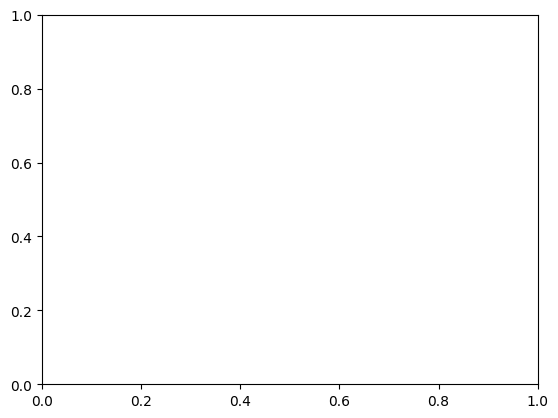

In [9]:
# ax=plt.plot(l, sr_list, label='SR')
# ax.plot(l, pnl_list, label='Cum P/L',secondary_y=True,ax=ax)
# plt.legend()
# plt.show()
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# First plot on primary y-axis
ax1.plot(l, sr_list, label='SR', color='blue')
ax1.set_ylabel('SR', color='blue')

# Create secondary y-axis
ax2 = ax1.twinx()
# ax2.plot(l, pnl_list, label='Cum P/L', color='green')
# ax2.set_ylabel('Cum P/L', color='green')

ax2.plot(l, hit_list, label='Hit Rate', color='green')
ax2.set_ylabel('Hit Rate', color='green')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')
plt.title('SR and Cum P/L for PA 6.7% due 36 vs Rates_Hg_Frac')
plt.title('SR and Hit Rate for PA 6.7% due 36 vs Rates_Hg_Frac')

plt.show()

In [ ]:
# # bond.iloc[40:]
# rates.iloc[40:]['Rates_Hg'].apply(lambda x: eval(str(x)[2:])).plot()
# plt.ylabel('CT used')
# plt.xlabel('Date of trade entry')
# plt.title('CT used vs. time')
# plt.show()

In [ ]:
dq[['PANAMA 6.7% due 36 Price']].plot()

In [ ]:

#                 ###########################################################################################################################

#                 sr = bt_df.copy()
#                 sr['Sum'] = sr.sum(axis=1)
#                 sr = sr[['Sum']]
#                 sr = sr.cumsum().resample("D").last().dropna().copy()
#                 sr += 10**7
#                 sr = sr.pct_change()
#                 sr = round((252**0.5*sr.mean()/sr.std()).iloc[0],3)
                
#                 globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_$pnl'].\
#                 loc[strategy_zscore_entry,strategy_zscore_exit] = round(bt_df.sum().sum(),0)
#                 globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_$pnl/trade'].\
#                 loc[strategy_zscore_entry,strategy_zscore_exit] = round(bt_df.sum().sum()/trade_num,0)
#                 globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_SR'].\
#                 loc[strategy_zscore_entry,strategy_zscore_exit] = round(sr,2)
#                 globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_trades'].\
#                 loc[strategy_zscore_entry,strategy_zscore_exit] = trade_num

#                 bt_df['Sum'] = bt_df.sum(axis=1)
#                 pos = len(bt_df[bt_df['Sum']>0])
#                 neg = len(bt_df[bt_df['Sum']<0])
#                 try:
#                     hit = round((pos/(pos+neg))*100,0)
#                 except:
#                     hit = 0
#                 globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_Hit Ratio'].\
#                 loc[strategy_zscore_entry,strategy_zscore_exit] = round(hit,0)
    
#                 max_dd = bt_df[['Sum']].cumsum().copy()
#                 max_dd['Roll Max'] = max_dd[['Sum']].rolling(window=10000000, min_periods=1).max()
#                 max_dd['Diff'] = abs(max_dd['Roll Max'] - max_dd['Sum'])
#                 globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_max DD'].\
#                 loc[strategy_zscore_entry,strategy_zscore_exit] = round(-1*max_dd['Diff'].max(),0)
                
#                 ############################### Plots
                
#                 dates3, values3 = zip(*strat1.scatter_plot_trade_pnl)
#                 d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
#                 dates3, values3 = zip(*strat2.scatter_plot_trade_pnl)
#                 d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
    
#                 if len(model_X) == 1:
#                     d5 = pd.concat([d3,d4],axis=1).dropna().copy()
    
#                 elif len(model_X) == 2:
#                     dates3, values3 = zip(*strat3.scatter_plot_trade_pnl)
#                     d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
#                     d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                
#                 scatter = pd.concat([bt_df[['Sum']],d5['CDX']],axis=1)
#                 # scatter = pd.concat([bt_df[['Sum']],d3['CDX']],axis=1)
#                 x = scatter[scatter['Sum']!=0.0]['CDX'].copy()
#                 bar_size = sampling_multiplier if dict_models[model_num][0] == 'Intraday' else np.nan
                
#                 globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_days/trade'].\
#                 loc[strategy_zscore_entry,strategy_zscore_exit] = round(x.sum()/(bar_size*len(x)),1)
                
#                 title = f"{global_model}; Model {dict_models[model_num][-1]}; {strategy_zscore_entry} entry; {trade_btdf_direction} direction"
#                 title += f" & {strategy_zscore_exit} exit; P/L: {bt_df[['Sum']].cumsum().iloc[-1,0]:.0f}; SR: {sr:.2f}"
#                 title += f" & Diff: {str(diff_period_list)}"
                
#                 dates3, values3 = zip(*strat1.scatter_plot_trade_pnl)
#                 d3 = pd.DataFrame({ 'CDX':list(values3)}, index = list(dates3))
#                 dates3, values3 = zip(*strat2.scatter_plot_trade_pnl)
#                 d4 = pd.DataFrame({ 'SPX':list(values3)}, index = list(dates3))
                
#                 if (model_X) == 1:
#                     d5 = pd.concat([d3,d4],axis=1).dropna().copy()
    
#                 elif len(model_X) == 2:
#                     dates3, values3 = zip(*strat3.scatter_plot_trade_pnl)
#                     d41 = pd.DataFrame({ 'SPX2':list(values3)}, index = list(dates3))
#                     d5 = pd.concat([d3,d4,d41],axis=1).dropna().copy()
                
#                 d5 = d5/bar_size
#                 scatter = pd.concat([bt_df[['Sum']],d5['CDX']],axis=1)
#                 scatter = scatter[scatter['Sum']!=0.0]
#                 plt.figure(figsize=(12,6))
#                 plt.scatter(scatter['CDX'], scatter['Sum'],label="Per Trade P/L")
#                 plt.ylabel("Trade $P/L")
#                 plt.xlabel("Trade Duration in Days")
#                 plt.title(title)
#                 plt.legend()
#                 plt.savefig(f"Plots/Scatter/{title.replace(";","_").replace("/","_").replace("&","_").replace(":","_")}.png")
#                 # plt.show()
#                 plt.close()
                 
#                 bt_df['Sum'].cumsum().plot(label="Cum. P/L", figsize=(12,6))
#                 plt.title(title)
#                 plt.legend()
#                 plt.savefig(f"Plots/PL/{title.replace(";","_").replace("/","_").replace("&","_").replace(":","_")}.png")
#                 # plt.show()
#                 plt.close()
#                 ############################### Plots


# display(dfx.iloc[[0,-1],:])

# for trade_btdf_direction in ['Long/Short']: #'Long','Short',
#     print(f'global model is {global_model}')
#     print(f'model_num is {model_num}')
#     print(f'trade direction is {trade_btdf_direction}')
#     for info in ['$pnl','$pnl/trade','SR','Hit Ratio','trades','days/trade','max DD']:
#         display(globals()[f'{global_model}_{model_num}_{trade_btdf_direction}_{info}'])